In [258]:
%matplotlib inline

In [259]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical
from torch.autograd import Variable

env = gym.make('MountainCar-v0').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cpu
Number of actions : 3


In [260]:
MEMSIZE = 70000
  
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [261]:

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(2, 32)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(32, 32)
        self.l4 = nn.ReLU()
        self.l5 = nn.Linear(32, 3)
        self.init_weights()

    def init_weights(layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_normal(layer.weight)

    def forward(self, x):
        #x = x.float()
        x = (self.l1(x))
        x = (self.l2(x))
        x = (self.l3(x))
        x = (self.l4(x))
        x = (self.l5(x))
        return x

In [263]:
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4, amsgrad=True)

memory = ReplayMemory(50000)


EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

steps_done = 0

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [265]:

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.tensor(next_state).to(device).float()

    state_batch =  torch.tensor(batch.state).to(device).float()
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(0)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

In [266]:
TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample < eps_threshold:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)
    return policy_net(torch.tensor(state).to(device).float()).max(0)[1].view(1, 1)

Target net updated!
10000
episode: 0   score: -15702.0   mean: -15702.0
Target net updated!
20000
Target net updated!
30000
episode: 1   score: -14742.0   mean: -15222.0
Target net updated!
40000
Target net updated!
50000
start train
Target net updated!
60000
episode: 2   score: -37382.0   mean: -22608.666666666668
Target net updated!
70000
Target net updated!
80000
episode: 3   score: -18598.0   mean: -21606.0
Target net updated!
90000
episode: 4   score: -9156.0   mean: -19116.0
episode: 5   score: -1593.0   mean: -16195.5
Target net updated!
100000
episode: 6   score: -4734.0   mean: -14558.142857142857
episode: 7   score: -2775.0   mean: -13085.25
episode: 8   score: -4005.0   mean: -12076.333333333334
episode: 9   score: -803.0   mean: -10949.0
Target net updated!
110000
episode: 10   score: -2055.0   mean: -10140.454545454546
episode: 11   score: -6254.0   mean: -9816.583333333334
episode: 12   score: -2036.0   mean: -9218.076923076924
Target net updated!
120000
episode: 13   sco

episode: 148   score: -586.0   mean: -796.35
episode: 149   score: -571.0   mean: -784.73
episode: 150   score: -591.0   mean: -783.5
episode: 151   score: -954.0   mean: -756.86
episode: 152   score: -1156.0   mean: -756.36
episode: 153   score: -379.0   mean: -745.62
episode: 154   score: -448.0   mean: -741.98
episode: 155   score: -504.0   mean: -740.3
Target net updated!
260000
episode: 156   score: -412.0   mean: -735.44
episode: 157   score: -513.0   mean: -732.65
episode: 158   score: -580.0   mean: -731.12
episode: 159   score: -455.0   mean: -728.25
episode: 160   score: -742.0   mean: -725.38
episode: 161   score: -972.0   mean: -729.58
episode: 162   score: -314.0   mean: -727.21
episode: 163   score: -513.0   mean: -724.86
episode: 164   score: -1065.0   mean: -729.44
episode: 165   score: -955.0   mean: -730.95
episode: 166   score: -342.0   mean: -717.97
episode: 167   score: -546.0   mean: -718.96
episode: 168   score: -513.0   mean: -711.66
episode: 169   score: -500.0

episode: 325   score: -712.0   mean: -476.84
episode: 326   score: -321.0   mean: -476.16
episode: 327   score: -384.0   mean: -475.62
episode: 328   score: -468.0   mean: -474.9
episode: 329   score: -326.0   mean: -474.85
episode: 330   score: -393.0   mean: -474.6
Target net updated!
350000
episode: 331   score: -564.0   mean: -469.84
episode: 332   score: -632.0   mean: -470.0
episode: 333   score: -482.0   mean: -467.76
episode: 334   score: -630.0   mean: -468.16
episode: 335   score: -564.0   mean: -467.28
episode: 336   score: -390.0   mean: -465.9
episode: 337   score: -612.0   mean: -467.93
episode: 338   score: -234.0   mean: -466.12
episode: 339   score: -326.0   mean: -466.06
episode: 340   score: -420.0   mean: -466.98
episode: 341   score: -433.0   mean: -466.44
episode: 342   score: -291.0   mean: -460.07
episode: 343   score: -388.0   mean: -459.9
episode: 344   score: -514.0   mean: -460.97
episode: 345   score: -522.0   mean: -460.93
episode: 346   score: -602.0   me

episode: 503   score: -488.0   mean: -394.06
episode: 504   score: -375.0   mean: -394.14
episode: 505   score: -231.0   mean: -392.96
episode: 506   score: -415.0   mean: -392.53
episode: 507   score: -322.0   mean: -391.77
episode: 508   score: -436.0   mean: -389.28
episode: 509   score: -395.0   mean: -389.53
episode: 510   score: -315.0   mean: -389.1
episode: 511   score: -253.0   mean: -388.29
episode: 512   score: -289.0   mean: -388.58
episode: 513   score: -803.0   mean: -393.79
episode: 514   score: -246.0   mean: -392.82
episode: 515   score: -344.0   mean: -391.46
episode: 516   score: -285.0   mean: -390.2
episode: 517   score: -248.0   mean: -388.4
episode: 518   score: -320.0   mean: -386.67
episode: 519   score: -273.0   mean: -385.95
episode: 520   score: -434.0   mean: -386.31
episode: 521   score: -349.0   mean: -386.42
episode: 522   score: -322.0   mean: -386.01
episode: 523   score: -338.0   mean: -386.01
episode: 524   score: -356.0   mean: -384.54
episode: 525 

episode: 682   score: -328.0   mean: -339.14
episode: 683   score: -447.0   mean: -339.71
episode: 684   score: -288.0   mean: -337.87
episode: 685   score: -249.0   mean: -335.89
episode: 686   score: -415.0   mean: -334.67
episode: 687   score: -252.0   mean: -333.93
episode: 688   score: -394.0   mean: -334.73
episode: 689   score: -302.0   mean: -335.49
episode: 690   score: -341.0   mean: -334.62
episode: 691   score: -358.0   mean: -334.66
episode: 692   score: -347.0   mean: -335.39
episode: 693   score: -273.0   mean: -335.58
episode: 694   score: -338.0   mean: -337.17
episode: 695   score: -276.0   mean: -337.65
episode: 696   score: -373.0   mean: -337.96
episode: 697   score: -277.0   mean: -335.98
episode: 698   score: -208.0   mean: -333.74
episode: 699   score: -440.0   mean: -335.47
episode: 700   score: -232.0   mean: -334.57
episode: 701   score: -247.0   mean: -332.6
episode: 702   score: -272.0   mean: -332.02
episode: 703   score: -248.0   mean: -331.53
episode: 70

episode: 863   score: -437.0   mean: -291.32
episode: 864   score: -224.0   mean: -290.55
episode: 865   score: -235.0   mean: -289.33
episode: 866   score: -229.0   mean: -288.72
episode: 867   score: -233.0   mean: -288.53
episode: 868   score: -245.0   mean: -288.5
episode: 869   score: -317.0   mean: -288.51
episode: 870   score: -237.0   mean: -288.52
episode: 871   score: -320.0   mean: -288.35
episode: 872   score: -325.0   mean: -289.24
episode: 873   score: -343.0   mean: -288.02
episode: 874   score: -238.0   mean: -288.21
Target net updated!
540000
episode: 875   score: -319.0   mean: -288.91
episode: 876   score: -203.0   mean: -288.17
episode: 877   score: -292.0   mean: -288.75
episode: 878   score: -332.0   mean: -288.15
episode: 879   score: -253.0   mean: -288.22
episode: 880   score: -253.0   mean: -288.24
episode: 881   score: -266.0   mean: -287.53
episode: 882   score: -250.0   mean: -287.62
episode: 883   score: -200.0   mean: -286.95
episode: 884   score: -246.0 

episode: 1042   score: -261.0   mean: -267.37
episode: 1043   score: -258.0   mean: -266.65
episode: 1044   score: -232.0   mean: -266.52
episode: 1045   score: -245.0   mean: -266.62
episode: 1046   score: -239.0   mean: -266.43
episode: 1047   score: -241.0   mean: -264.9
episode: 1048   score: -249.0   mean: -264.89
episode: 1049   score: -238.0   mean: -262.91
episode: 1050   score: -231.0   mean: -261.17
episode: 1051   score: -240.0   mean: -260.19
episode: 1052   score: -305.0   mean: -260.1
episode: 1053   score: -231.0   mean: -260.07
episode: 1054   score: -224.0   mean: -260.12
episode: 1055   score: -246.0   mean: -260.23
episode: 1056   score: -317.0   mean: -261.23
episode: 1057   score: -243.0   mean: -261.28
episode: 1058   score: -366.0   mean: -262.86
episode: 1059   score: -225.0   mean: -262.66
Target net updated!
590000
episode: 1060   score: -229.0   mean: -262.6
episode: 1061   score: -245.0   mean: -262.63
episode: 1062   score: -199.0   mean: -261.7
episode: 10

episode: 1218   score: -244.0   mean: -255.71
episode: 1219   score: -224.0   mean: -255.42
episode: 1220   score: -196.0   mean: -255.25
episode: 1221   score: -236.0   mean: -255.12
episode: 1222   score: -322.0   mean: -256.2
episode: 1223   score: -244.0   mean: -256.71
episode: 1224   score: -198.0   mean: -256.22
episode: 1225   score: -329.0   mean: -257.12
episode: 1226   score: -170.0   mean: -255.9
episode: 1227   score: -247.0   mean: -256.59
episode: 1228   score: -217.0   mean: -256.39
episode: 1229   score: -230.0   mean: -255.06
episode: 1230   score: -199.0   mean: -254.63
episode: 1231   score: -228.0   mean: -254.56
episode: 1232   score: -197.0   mean: -254.09
episode: 1233   score: -234.0   mean: -254.14
episode: 1234   score: -256.0   mean: -254.2
episode: 1235   score: -237.0   mean: -253.99
episode: 1236   score: -235.0   mean: -253.86
episode: 1237   score: -256.0   mean: -253.28
episode: 1238   score: -262.0   mean: -253.13
episode: 1239   score: -367.0   mean:

episode: 1395   score: -277.0   mean: -242.17
episode: 1396   score: -230.0   mean: -242.34
episode: 1397   score: -255.0   mean: -241.45
episode: 1398   score: -241.0   mean: -241.49
episode: 1399   score: -246.0   mean: -241.61
episode: 1400   score: -238.0   mean: -242.0
episode: 1401   score: -243.0   mean: -241.54
episode: 1402   score: -240.0   mean: -241.86
episode: 1403   score: -268.0   mean: -242.49
episode: 1404   score: -264.0   mean: -243.18
episode: 1405   score: -334.0   mean: -243.99
episode: 1406   score: -177.0   mean: -243.24
episode: 1407   score: -230.0   mean: -243.16
episode: 1408   score: -279.0   mean: -243.51
episode: 1409   score: -260.0   mean: -242.96
episode: 1410   score: -246.0   mean: -242.93
episode: 1411   score: -243.0   mean: -242.99
episode: 1412   score: -163.0   mean: -241.04
episode: 1413   score: -161.0   mean: -240.28
episode: 1414   score: -409.0   mean: -242.7
episode: 1415   score: -330.0   mean: -243.28
episode: 1416   score: -158.0   mean

episode: 1572   score: -222.0   mean: -230.89
episode: 1573   score: -176.0   mean: -230.98
episode: 1574   score: -253.0   mean: -231.67
episode: 1575   score: -292.0   mean: -232.56
episode: 1576   score: -226.0   mean: -232.26
episode: 1577   score: -206.0   mean: -231.76
episode: 1578   score: -210.0   mean: -231.59
episode: 1579   score: -232.0   mean: -231.34
episode: 1580   score: -175.0   mean: -231.51
episode: 1581   score: -239.0   mean: -232.2
episode: 1582   score: -244.0   mean: -232.25
episode: 1583   score: -201.0   mean: -232.25
episode: 1584   score: -244.0   mean: -232.22
episode: 1585   score: -245.0   mean: -232.16
episode: 1586   score: -234.0   mean: -231.84
episode: 1587   score: -201.0   mean: -231.45
episode: 1588   score: -247.0   mean: -231.44
episode: 1589   score: -249.0   mean: -231.54
episode: 1590   score: -248.0   mean: -232.04
Target net updated!
720000
episode: 1591   score: -268.0   mean: -232.37
episode: 1592   score: -210.0   mean: -232.06
episode:

episode: 1749   score: -223.0   mean: -224.32
episode: 1750   score: -246.0   mean: -224.47
episode: 1751   score: -166.0   mean: -223.1
episode: 1752   score: -238.0   mean: -222.91
episode: 1753   score: -248.0   mean: -222.96
episode: 1754   score: -248.0   mean: -223.03
episode: 1755   score: -225.0   mean: -222.74
episode: 1756   score: -242.0   mean: -222.87
episode: 1757   score: -322.0   mean: -223.97
episode: 1758   score: -203.0   mean: -224.4
episode: 1759   score: -268.0   mean: -224.58
episode: 1760   score: -225.0   mean: -224.02
episode: 1761   score: -245.0   mean: -224.15
episode: 1762   score: -235.0   mean: -223.98
episode: 1763   score: -364.0   mean: -225.59
episode: 1764   score: -165.0   mean: -225.52
episode: 1765   score: -256.0   mean: -225.76
Target net updated!
760000
episode: 1766   score: -237.0   mean: -226.42
episode: 1767   score: -176.0   mean: -225.78
episode: 1768   score: -240.0   mean: -225.8
episode: 1769   score: -210.0   mean: -225.54
episode: 1

episode: 1927   score: -247.0   mean: -210.46
episode: 1928   score: -161.0   mean: -210.07
episode: 1929   score: -174.0   mean: -210.1
episode: 1930   score: -161.0   mean: -209.35
episode: 1931   score: -246.0   mean: -209.42
episode: 1932   score: -249.0   mean: -209.55
episode: 1933   score: -246.0   mean: -209.59
episode: 1934   score: -155.0   mean: -208.91
episode: 1935   score: -234.0   mean: -208.74
episode: 1936   score: -218.0   mean: -209.15
episode: 1937   score: -165.0   mean: -209.08
episode: 1938   score: -153.0   mean: -208.09
episode: 1939   score: -244.0   mean: -208.16
episode: 1940   score: -201.0   mean: -207.69
episode: 1941   score: -166.0   mean: -207.68
episode: 1942   score: -159.0   mean: -206.86
episode: 1943   score: -200.0   mean: -206.77
episode: 1944   score: -175.0   mean: -206.93
episode: 1945   score: -160.0   mean: -206.15
episode: 1946   score: -326.0   mean: -207.77
episode: 1947   score: -171.0   mean: -206.91
episode: 1948   score: -169.0   mea

episode: 2104   score: -244.0   mean: -206.29
episode: 2105   score: -250.0   mean: -207.22
episode: 2106   score: -257.0   mean: -207.34
episode: 2107   score: -168.0   mean: -207.34
episode: 2108   score: -171.0   mean: -207.15
episode: 2109   score: -231.0   mean: -207.89
episode: 2110   score: -266.0   mean: -207.57
episode: 2111   score: -237.0   mean: -207.65
episode: 2112   score: -165.0   mean: -206.85
episode: 2113   score: -165.0   mean: -206.5
episode: 2114   score: -214.0   mean: -207.06
episode: 2115   score: -196.0   mean: -206.71
episode: 2116   score: -167.0   mean: -206.75
episode: 2117   score: -260.0   mean: -207.72
episode: 2118   score: -155.0   mean: -206.9
episode: 2119   score: -237.0   mean: -206.87
episode: 2120   score: -162.0   mean: -206.1
episode: 2121   score: -259.0   mean: -204.9
episode: 2122   score: -248.0   mean: -205.47
episode: 2123   score: -243.0   mean: -206.23
episode: 2124   score: -158.0   mean: -205.5
episode: 2125   score: -262.0   mean: -

episode: 2281   score: -199.0   mean: -203.54
episode: 2282   score: -249.0   mean: -203.66
episode: 2283   score: -232.0   mean: -204.37
episode: 2284   score: -191.0   mean: -203.69
episode: 2285   score: -222.0   mean: -204.26
episode: 2286   score: -167.0   mean: -203.39
episode: 2287   score: -163.0   mean: -202.89
episode: 2288   score: -238.0   mean: -203.58
episode: 2289   score: -221.0   mean: -203.18
episode: 2290   score: -201.0   mean: -203.56
episode: 2291   score: -158.0   mean: -203.0
episode: 2292   score: -170.0   mean: -202.25
Target net updated!
870000
episode: 2293   score: -222.0   mean: -202.21
episode: 2294   score: -171.0   mean: -202.32
episode: 2295   score: -241.0   mean: -202.18
episode: 2296   score: -242.0   mean: -202.92
episode: 2297   score: -169.0   mean: -202.48
episode: 2298   score: -163.0   mean: -201.74
episode: 2299   score: -162.0   mean: -201.77
episode: 2300   score: -229.0   mean: -201.61
episode: 2301   score: -254.0   mean: -201.98
episode:

episode: 2459   score: -225.0   mean: -198.38
episode: 2460   score: -201.0   mean: -198.46
episode: 2461   score: -181.0   mean: -197.89
episode: 2462   score: -216.0   mean: -198.07
episode: 2463   score: -140.0   mean: -197.85
episode: 2464   score: -156.0   mean: -197.83
episode: 2465   score: -183.0   mean: -198.02
episode: 2466   score: -159.0   mean: -197.9
episode: 2467   score: -247.0   mean: -197.86
episode: 2468   score: -200.0   mean: -198.27
episode: 2469   score: -161.0   mean: -198.17
episode: 2470   score: -201.0   mean: -198.52
episode: 2471   score: -283.0   mean: -199.78
episode: 2472   score: -198.0   mean: -199.12
episode: 2473   score: -259.0   mean: -199.49
episode: 2474   score: -234.0   mean: -199.22
episode: 2475   score: -250.0   mean: -199.68
episode: 2476   score: -242.0   mean: -200.54
episode: 2477   score: -165.0   mean: -200.39
episode: 2478   score: -168.0   mean: -199.54
episode: 2479   score: -201.0   mean: -199.15
episode: 2480   score: -162.0   mea

episode: 2636   score: -159.0   mean: -193.41
episode: 2637   score: -221.0   mean: -194.04
episode: 2638   score: -161.0   mean: -194.04
episode: 2639   score: -165.0   mean: -193.05
episode: 2640   score: -153.0   mean: -192.38
episode: 2641   score: -260.0   mean: -193.03
episode: 2642   score: -126.0   mean: -192.62
episode: 2643   score: -240.0   mean: -192.68
episode: 2644   score: -171.0   mean: -192.82
episode: 2645   score: -252.0   mean: -193.39
episode: 2646   score: -230.0   mean: -193.96
episode: 2647   score: -182.0   mean: -194.15
episode: 2648   score: -150.0   mean: -193.35
Target net updated!
940000
episode: 2649   score: -161.0   mean: -193.4
episode: 2650   score: -237.0   mean: -193.64
episode: 2651   score: -232.0   mean: -193.59
episode: 2652   score: -161.0   mean: -193.57
episode: 2653   score: -167.0   mean: -192.46
episode: 2654   score: -228.0   mean: -193.12
episode: 2655   score: -165.0   mean: -193.2
episode: 2656   score: -170.0   mean: -193.12
episode: 

episode: 2814   score: -245.0   mean: -185.83
episode: 2815   score: -168.0   mean: -185.89
episode: 2816   score: -233.0   mean: -186.24
episode: 2817   score: -170.0   mean: -186.26
episode: 2818   score: -163.0   mean: -186.24
episode: 2819   score: -162.0   mean: -185.8
episode: 2820   score: -162.0   mean: -185.81
episode: 2821   score: -196.0   mean: -186.16
episode: 2822   score: -156.0   mean: -185.38
episode: 2823   score: -194.0   mean: -185.66
episode: 2824   score: -218.0   mean: -185.48
episode: 2825   score: -221.0   mean: -185.94
episode: 2826   score: -238.0   mean: -186.35
episode: 2827   score: -232.0   mean: -187.0
episode: 2828   score: -163.0   mean: -187.03
episode: 2829   score: -178.0   mean: -187.2
episode: 2830   score: -157.0   mean: -186.3
episode: 2831   score: -236.0   mean: -187.09
episode: 2832   score: -194.0   mean: -187.38
episode: 2833   score: -200.0   mean: -187.38
episode: 2834   score: -188.0   mean: -187.12
episode: 2835   score: -231.0   mean: 

episode: 2991   score: -178.0   mean: -181.98
episode: 2992   score: -163.0   mean: -181.38
episode: 2993   score: -157.0   mean: -181.33
episode: 2994   score: -159.0   mean: -181.16
episode: 2995   score: -163.0   mean: -181.11
episode: 2996   score: -246.0   mean: -181.61
episode: 2997   score: -237.0   mean: -181.62
episode: 2998   score: -158.0   mean: -181.07
episode: 2999   score: -165.0   mean: -181.17
episode: 3000   score: -233.0   mean: -181.9
episode: 3001   score: -156.0   mean: -181.79
episode: 3002   score: -187.0   mean: -182.02
episode: 3003   score: -164.0   mean: -182.12
episode: 3004   score: -146.0   mean: -181.97
episode: 3005   score: -266.0   mean: -183.04
episode: 3006   score: -160.0   mean: -183.0
episode: 3007   score: -200.0   mean: -183.42
episode: 3008   score: -158.0   mean: -183.2
episode: 3009   score: -153.0   mean: -182.51
episode: 3010   score: -193.0   mean: -182.87
episode: 3011   score: -156.0   mean: -182.76
episode: 3012   score: -163.0   mean:

episode: 3169   score: -223.0   mean: -181.12
episode: 3170   score: -155.0   mean: -180.93
episode: 3171   score: -162.0   mean: -180.57
episode: 3172   score: -164.0   mean: -180.53
episode: 3173   score: -254.0   mean: -181.49
episode: 3174   score: -155.0   mean: -180.65
episode: 3175   score: -162.0   mean: -180.65
episode: 3176   score: -233.0   mean: -180.85
episode: 3177   score: -174.0   mean: -180.79
episode: 3178   score: -201.0   mean: -181.01
episode: 3179   score: -155.0   mean: -180.94
episode: 3180   score: -158.0   mean: -180.96
episode: 3181   score: -237.0   mean: -181.63
episode: 3182   score: -163.0   mean: -181.72
episode: 3183   score: -167.0   mean: -181.85
episode: 3184   score: -174.0   mean: -182.02
episode: 3185   score: -159.0   mean: -181.2
episode: 3186   score: -160.0   mean: -180.35
episode: 3187   score: -183.0   mean: -180.33
episode: 3188   score: -159.0   mean: -180.41
episode: 3189   score: -164.0   mean: -179.52
episode: 3190   score: -147.0   mea

episode: 3346   score: -160.0   mean: -177.3
episode: 3347   score: -169.0   mean: -177.38
episode: 3348   score: -164.0   mean: -177.45
episode: 3349   score: -158.0   mean: -177.48
episode: 3350   score: -166.0   mean: -176.45
episode: 3351   score: -209.0   mean: -177.19
episode: 3352   score: -164.0   mean: -177.17
episode: 3353   score: -248.0   mean: -178.02
episode: 3354   score: -141.0   mean: -177.74
episode: 3355   score: -164.0   mean: -177.82
episode: 3356   score: -249.0   mean: -178.61
episode: 3357   score: -241.0   mean: -179.49
episode: 3358   score: -150.0   mean: -179.39
Target net updated!
1070000
episode: 3359   score: -151.0   mean: -179.26
episode: 3360   score: -164.0   mean: -178.36
episode: 3361   score: -162.0   mean: -178.3
episode: 3362   score: -228.0   mean: -179.36
episode: 3363   score: -168.0   mean: -179.18
episode: 3364   score: -126.0   mean: -178.7
episode: 3365   score: -165.0   mean: -178.72
episode: 3366   score: -194.0   mean: -179.19
episode: 

episode: 3524   score: -159.0   mean: -182.44
Target net updated!
1100000
episode: 3525   score: -155.0   mean: -182.49
episode: 3526   score: -209.0   mean: -182.95
episode: 3527   score: -194.0   mean: -183.35
episode: 3528   score: -157.0   mean: -183.11
episode: 3529   score: -223.0   mean: -183.27
episode: 3530   score: -158.0   mean: -183.23
episode: 3531   score: -158.0   mean: -183.13
episode: 3532   score: -159.0   mean: -182.18
episode: 3533   score: -174.0   mean: -182.64
episode: 3534   score: -234.0   mean: -182.44
episode: 3535   score: -172.0   mean: -182.48
episode: 3536   score: -156.0   mean: -182.53
episode: 3537   score: -151.0   mean: -182.53
episode: 3538   score: -180.0   mean: -182.55
episode: 3539   score: -160.0   mean: -182.57
episode: 3540   score: -163.0   mean: -181.62
episode: 3541   score: -161.0   mean: -181.58
episode: 3542   score: -207.0   mean: -182.02
episode: 3543   score: -162.0   mean: -181.1
episode: 3544   score: -152.0   mean: -180.63
episode

episode: 3701   score: -160.0   mean: -175.97
episode: 3702   score: -154.0   mean: -175.85
episode: 3703   score: -157.0   mean: -175.7
episode: 3704   score: -156.0   mean: -174.84
episode: 3705   score: -162.0   mean: -173.93
episode: 3706   score: -155.0   mean: -173.05
episode: 3707   score: -166.0   mean: -173.14
episode: 3708   score: -160.0   mean: -173.19
episode: 3709   score: -169.0   mean: -173.25
episode: 3710   score: -154.0   mean: -173.17
episode: 3711   score: -252.0   mean: -174.01
episode: 3712   score: -162.0   mean: -174.09
episode: 3713   score: -158.0   mean: -173.95
episode: 3714   score: -155.0   mean: -173.41
episode: 3715   score: -167.0   mean: -173.54
episode: 3716   score: -227.0   mean: -173.52
episode: 3717   score: -160.0   mean: -173.51
episode: 3718   score: -154.0   mean: -173.07
episode: 3719   score: -185.0   mean: -173.39
episode: 3720   score: -201.0   mean: -173.83
episode: 3721   score: -160.0   mean: -173.9
episode: 3722   score: -156.0   mean

episode: 3878   score: -161.0   mean: -171.8
episode: 3879   score: -154.0   mean: -171.76
episode: 3880   score: -160.0   mean: -171.8
episode: 3881   score: -255.0   mean: -172.72
episode: 3882   score: -157.0   mean: -172.63
episode: 3883   score: -183.0   mean: -172.84
episode: 3884   score: -167.0   mean: -172.8
episode: 3885   score: -164.0   mean: -172.45
episode: 3886   score: -167.0   mean: -172.49
episode: 3887   score: -159.0   mean: -172.05
episode: 3888   score: -154.0   mean: -172.0
episode: 3889   score: -164.0   mean: -172.01
episode: 3890   score: -167.0   mean: -172.12
episode: 3891   score: -177.0   mean: -172.33
episode: 3892   score: -198.0   mean: -172.72
episode: 3893   score: -160.0   mean: -172.7
episode: 3894   score: -162.0   mean: -172.67
episode: 3895   score: -168.0   mean: -172.36
episode: 3896   score: -164.0   mean: -172.27
episode: 3897   score: -162.0   mean: -172.31
episode: 3898   score: -161.0   mean: -172.4
episode: 3899   score: -197.0   mean: -1

episode: 4055   score: -158.0   mean: -170.6
episode: 4056   score: -164.0   mean: -170.62
episode: 4057   score: -160.0   mean: -170.67
episode: 4058   score: -127.0   mean: -170.35
episode: 4059   score: -151.0   mean: -170.32
episode: 4060   score: -177.0   mean: -170.52
episode: 4061   score: -121.0   mean: -170.15
episode: 4062   score: -161.0   mean: -170.17
episode: 4063   score: -167.0   mean: -170.28
episode: 4064   score: -157.0   mean: -169.43
episode: 4065   score: -158.0   mean: -168.68
episode: 4066   score: -160.0   mean: -168.78
episode: 4067   score: -158.0   mean: -168.79
episode: 4068   score: -156.0   mean: -168.06
episode: 4069   score: -168.0   mean: -168.2
episode: 4070   score: -165.0   mean: -168.17
episode: 4071   score: -159.0   mean: -167.23
episode: 4072   score: -169.0   mean: -167.01
episode: 4073   score: -162.0   mean: -167.01
episode: 4074   score: -165.0   mean: -166.98
episode: 4075   score: -130.0   mean: -166.61
episode: 4076   score: -160.0   mean

episode: 4233   score: -161.0   mean: -167.7
episode: 4234   score: -152.0   mean: -167.66
episode: 4235   score: -153.0   mean: -167.11
episode: 4236   score: -151.0   mean: -167.1
episode: 4237   score: -202.0   mean: -167.49
episode: 4238   score: -152.0   mean: -167.4
episode: 4239   score: -160.0   mean: -167.43
episode: 4240   score: -156.0   mean: -166.59
episode: 4241   score: -168.0   mean: -166.65
episode: 4242   score: -245.0   mean: -167.48
episode: 4243   score: -139.0   mean: -167.23
episode: 4244   score: -164.0   mean: -167.29
episode: 4245   score: -156.0   mean: -167.31
episode: 4246   score: -155.0   mean: -167.23
episode: 4247   score: -157.0   mean: -167.2
episode: 4248   score: -163.0   mean: -167.27
episode: 4249   score: -156.0   mean: -167.38
episode: 4250   score: -151.0   mean: -167.29
episode: 4251   score: -154.0   mean: -167.29
episode: 4252   score: -155.0   mean: -167.28
episode: 4253   score: -153.0   mean: -166.71
episode: 4254   score: -157.0   mean: 

episode: 4410   score: -160.0   mean: -165.93
episode: 4411   score: -161.0   mean: -165.86
episode: 4412   score: -161.0   mean: -165.93
episode: 4413   score: -155.0   mean: -165.92
episode: 4414   score: -168.0   mean: -166.3
episode: 4415   score: -166.0   mean: -166.27
episode: 4416   score: -166.0   mean: -166.42
episode: 4417   score: -157.0   mean: -166.36
episode: 4418   score: -157.0   mean: -166.29
episode: 4419   score: -164.0   mean: -165.44
episode: 4420   score: -192.0   mean: -165.34
episode: 4421   score: -159.0   mean: -164.87
episode: 4422   score: -270.0   mean: -165.12
episode: 4423   score: -163.0   mean: -165.23
episode: 4424   score: -160.0   mean: -165.19
episode: 4425   score: -159.0   mean: -165.14
episode: 4426   score: -150.0   mean: -165.14
episode: 4427   score: -164.0   mean: -165.18
episode: 4428   score: -161.0   mean: -165.27
episode: 4429   score: -134.0   mean: -164.97
episode: 4430   score: -168.0   mean: -164.99
episode: 4431   score: -163.0   mea

episode: 4588   score: -161.0   mean: -161.51
episode: 4589   score: -159.0   mean: -161.58
episode: 4590   score: -156.0   mean: -161.61
Target net updated!
1280000
episode: 4591   score: -163.0   mean: -161.71
episode: 4592   score: -161.0   mean: -161.83
episode: 4593   score: -160.0   mean: -161.63
episode: 4594   score: -129.0   mean: -161.31
episode: 4595   score: -163.0   mean: -161.45
episode: 4596   score: -156.0   mean: -161.45
episode: 4597   score: -204.0   mean: -161.84
episode: 4598   score: -166.0   mean: -161.96
episode: 4599   score: -215.0   mean: -162.52
episode: 4600   score: -136.0   mean: -162.37
episode: 4601   score: -148.0   mean: -162.34
episode: 4602   score: -154.0   mean: -162.32
episode: 4603   score: -148.0   mean: -162.21
episode: 4604   score: -153.0   mean: -162.18
episode: 4605   score: -163.0   mean: -162.53
episode: 4606   score: -161.0   mean: -162.61
episode: 4607   score: -161.0   mean: -162.61
episode: 4608   score: -165.0   mean: -162.7
episode

episode: 4765   score: -192.0   mean: -164.15
episode: 4766   score: -157.0   mean: -164.3
episode: 4767   score: -207.0   mean: -164.8
episode: 4768   score: -141.0   mean: -164.68
episode: 4769   score: -156.0   mean: -164.49
episode: 4770   score: -165.0   mean: -164.46
episode: 4771   score: -156.0   mean: -164.74
episode: 4772   score: -163.0   mean: -164.9
episode: 4773   score: -165.0   mean: -164.97
episode: 4774   score: -158.0   mean: -165.26
Target net updated!
1310000
episode: 4775   score: -160.0   mean: -165.26
episode: 4776   score: -169.0   mean: -165.34
episode: 4777   score: -155.0   mean: -165.31
episode: 4778   score: -203.0   mean: -165.77
episode: 4779   score: -153.0   mean: -165.68
episode: 4780   score: -156.0   mean: -165.29
episode: 4781   score: -226.0   mean: -165.98
episode: 4782   score: -159.0   mean: -165.89
episode: 4783   score: -167.0   mean: -165.99
episode: 4784   score: -165.0   mean: -166.23
episode: 4785   score: -159.0   mean: -166.28
episode: 

episode: 4943   score: -146.0   mean: -161.34
episode: 4944   score: -158.0   mean: -161.43
episode: 4945   score: -171.0   mean: -161.57
episode: 4946   score: -157.0   mean: -161.54
episode: 4947   score: -156.0   mean: -161.54
episode: 4948   score: -193.0   mean: -161.85
episode: 4949   score: -153.0   mean: -161.83
episode: 4950   score: -153.0   mean: -161.73
episode: 4951   score: -192.0   mean: -162.08
episode: 4952   score: -165.0   mean: -162.2
episode: 4953   score: -159.0   mean: -162.27
episode: 4954   score: -164.0   mean: -162.33
episode: 4955   score: -151.0   mean: -162.26
episode: 4956   score: -157.0   mean: -162.29
episode: 4957   score: -154.0   mean: -162.18
episode: 4958   score: -166.0   mean: -162.23
episode: 4959   score: -206.0   mean: -162.72
Target net updated!
1340000
episode: 4960   score: -232.0   mean: -163.42
episode: 4961   score: -153.0   mean: -163.38
episode: 4962   score: -156.0   mean: -163.36
episode: 4963   score: -161.0   mean: -163.42
episode

episode: 5120   score: -155.0   mean: -161.27
episode: 5121   score: -156.0   mean: -161.25
episode: 5122   score: -158.0   mean: -161.26
episode: 5123   score: -156.0   mean: -161.31
episode: 5124   score: -151.0   mean: -161.34
episode: 5125   score: -156.0   mean: -161.27
episode: 5126   score: -155.0   mean: -161.19
episode: 5127   score: -121.0   mean: -160.76
episode: 5128   score: -156.0   mean: -160.84
episode: 5129   score: -175.0   mean: -161.01
episode: 5130   score: -160.0   mean: -161.04
episode: 5131   score: -204.0   mean: -161.5
episode: 5132   score: -180.0   mean: -161.73
episode: 5133   score: -154.0   mean: -161.68
episode: 5134   score: -158.0   mean: -161.7
episode: 5135   score: -158.0   mean: -161.77
episode: 5136   score: -151.0   mean: -161.75
episode: 5137   score: -157.0   mean: -161.18
episode: 5138   score: -155.0   mean: -161.19
episode: 5139   score: -155.0   mean: -161.25
episode: 5140   score: -157.0   mean: -161.21
episode: 5141   score: -154.0   mean

episode: 5297   score: -159.0   mean: -159.48
episode: 5298   score: -161.0   mean: -159.56
episode: 5299   score: -146.0   mean: -159.47
episode: 5300   score: -159.0   mean: -159.46
episode: 5301   score: -149.0   mean: -159.41
episode: 5302   score: -154.0   mean: -159.39
episode: 5303   score: -155.0   mean: -158.97
episode: 5304   score: -162.0   mean: -159.02
episode: 5305   score: -154.0   mean: -159.04
episode: 5306   score: -159.0   mean: -159.02
episode: 5307   score: -149.0   mean: -159.0
episode: 5308   score: -153.0   mean: -159.01
episode: 5309   score: -164.0   mean: -159.12
episode: 5310   score: -203.0   mean: -159.6
episode: 5311   score: -156.0   mean: -159.51
episode: 5312   score: -158.0   mean: -159.53
episode: 5313   score: -158.0   mean: -159.5
episode: 5314   score: -158.0   mean: -159.49
episode: 5315   score: -161.0   mean: -159.52
episode: 5316   score: -163.0   mean: -159.15
episode: 5317   score: -157.0   mean: -159.2
episode: 5318   score: -153.0   mean: 

episode: 5474   score: -160.0   mean: -158.14
episode: 5475   score: -156.0   mean: -158.09
episode: 5476   score: -148.0   mean: -158.08
episode: 5477   score: -157.0   mean: -158.1
episode: 5478   score: -199.0   mean: -158.51
episode: 5479   score: -153.0   mean: -158.47
episode: 5480   score: -152.0   mean: -158.43
episode: 5481   score: -150.0   mean: -158.39
episode: 5482   score: -232.0   mean: -159.36
episode: 5483   score: -158.0   mean: -159.38
episode: 5484   score: -154.0   mean: -159.32
episode: 5485   score: -158.0   mean: -159.3
episode: 5486   score: -134.0   mean: -158.95
episode: 5487   score: -161.0   mean: -158.91
episode: 5488   score: -205.0   mean: -159.4
episode: 5489   score: -164.0   mean: -159.43
episode: 5490   score: -151.0   mean: -159.36
episode: 5491   score: -169.0   mean: -159.48
episode: 5492   score: -160.0   mean: -159.56
episode: 5493   score: -167.0   mean: -159.67
episode: 5494   score: -153.0   mean: -159.61
episode: 5495   score: -148.0   mean:

episode: 5652   score: -156.0   mean: -157.82
Target net updated!
1450000
episode: 5653   score: -163.0   mean: -157.84
episode: 5654   score: -153.0   mean: -157.82
episode: 5655   score: -158.0   mean: -158.12
episode: 5656   score: -152.0   mean: -158.04
episode: 5657   score: -157.0   mean: -158.08
episode: 5658   score: -166.0   mean: -158.16
episode: 5659   score: -133.0   mean: -157.97
episode: 5660   score: -152.0   mean: -157.93
episode: 5661   score: -158.0   mean: -158.06
episode: 5662   score: -167.0   mean: -158.15
episode: 5663   score: -162.0   mean: -158.14
episode: 5664   score: -158.0   mean: -158.32
episode: 5665   score: -164.0   mean: -158.39
episode: 5666   score: -156.0   mean: -158.4
episode: 5667   score: -164.0   mean: -158.47
episode: 5668   score: -157.0   mean: -158.71
episode: 5669   score: -153.0   mean: -158.66
episode: 5670   score: -161.0   mean: -158.67
episode: 5671   score: -155.0   mean: -158.23
episode: 5672   score: -189.0   mean: -158.55
episode

episode: 5829   score: -211.0   mean: -158.31
episode: 5830   score: -165.0   mean: -158.41
episode: 5831   score: -158.0   mean: -158.76
episode: 5832   score: -153.0   mean: -158.74
episode: 5833   score: -153.0   mean: -158.7
episode: 5834   score: -153.0   mean: -158.76
episode: 5835   score: -154.0   mean: -158.8
episode: 5836   score: -155.0   mean: -158.8
episode: 5837   score: -151.0   mean: -158.83
episode: 5838   score: -155.0   mean: -158.86
episode: 5839   score: -154.0   mean: -158.87
episode: 5840   score: -158.0   mean: -158.88
episode: 5841   score: -161.0   mean: -159.16
episode: 5842   score: -160.0   mean: -159.09
Target net updated!
1480000
episode: 5843   score: -211.0   mean: -159.45
episode: 5844   score: -154.0   mean: -158.97
episode: 5845   score: -159.0   mean: -159.02
episode: 5846   score: -156.0   mean: -159.06
episode: 5847   score: -144.0   mean: -158.42
episode: 5848   score: -146.0   mean: -158.39
episode: 5849   score: -148.0   mean: -158.36
episode: 

episode: 6006   score: -158.0   mean: -158.55
episode: 6007   score: -197.0   mean: -159.06
episode: 6008   score: -118.0   mean: -158.67
episode: 6009   score: -164.0   mean: -158.67
episode: 6010   score: -154.0   mean: -158.77
episode: 6011   score: -125.0   mean: -158.67
episode: 6012   score: -209.0   mean: -159.14
episode: 6013   score: -162.0   mean: -159.16
episode: 6014   score: -153.0   mean: -159.09
episode: 6015   score: -155.0   mean: -159.05
episode: 6016   score: -157.0   mean: -159.01
episode: 6017   score: -153.0   mean: -159.01
episode: 6018   score: -154.0   mean: -158.99
episode: 6019   score: -129.0   mean: -158.72
episode: 6020   score: -155.0   mean: -158.7
episode: 6021   score: -155.0   mean: -158.6
episode: 6022   score: -154.0   mean: -158.52
episode: 6023   score: -158.0   mean: -158.5
episode: 6024   score: -155.0   mean: -158.81
episode: 6025   score: -134.0   mean: -158.65
episode: 6026   score: -150.0   mean: -158.61
episode: 6027   score: -150.0   mean:

episode: 6183   score: -160.0   mean: -158.73
episode: 6184   score: -156.0   mean: -158.79
episode: 6185   score: -152.0   mean: -157.88
episode: 6186   score: -156.0   mean: -158.23
episode: 6187   score: -158.0   mean: -158.24
episode: 6188   score: -156.0   mean: -158.31
episode: 6189   score: -151.0   mean: -158.28
episode: 6190   score: -155.0   mean: -158.23
episode: 6191   score: -150.0   mean: -158.11
episode: 6192   score: -157.0   mean: -158.14
episode: 6193   score: -159.0   mean: -158.09
episode: 6194   score: -146.0   mean: -158.0
episode: 6195   score: -152.0   mean: -157.98
episode: 6196   score: -151.0   mean: -157.81
episode: 6197   score: -162.0   mean: -157.76
episode: 6198   score: -155.0   mean: -157.73
episode: 6199   score: -156.0   mean: -158.08
episode: 6200   score: -124.0   mean: -157.82
episode: 6201   score: -157.0   mean: -157.75
episode: 6202   score: -144.0   mean: -157.63
episode: 6203   score: -158.0   mean: -157.69
episode: 6204   score: -153.0   mea

episode: 6360   score: -154.0   mean: -157.3
episode: 6361   score: -200.0   mean: -157.76
episode: 6362   score: -155.0   mean: -157.8
episode: 6363   score: -156.0   mean: -157.75
episode: 6364   score: -156.0   mean: -157.76
episode: 6365   score: -157.0   mean: -157.75
episode: 6366   score: -128.0   mean: -157.52
episode: 6367   score: -150.0   mean: -157.38
episode: 6368   score: -153.0   mean: -157.3
episode: 6369   score: -174.0   mean: -157.5
episode: 6370   score: -160.0   mean: -157.52
episode: 6371   score: -159.0   mean: -157.56
episode: 6372   score: -159.0   mean: -157.61
episode: 6373   score: -151.0   mean: -157.58
episode: 6374   score: -159.0   mean: -157.54
episode: 6375   score: -150.0   mean: -157.47
episode: 6376   score: -156.0   mean: -157.4
episode: 6377   score: -155.0   mean: -157.38
episode: 6378   score: -157.0   mean: -157.37
episode: 6379   score: -149.0   mean: -157.34
episode: 6380   score: -192.0   mean: -157.68
episode: 6381   score: -161.0   mean: -

episode: 6538   score: -163.0   mean: -155.47
episode: 6539   score: -164.0   mean: -155.48
episode: 6540   score: -159.0   mean: -155.52
episode: 6541   score: -158.0   mean: -155.58
episode: 6542   score: -124.0   mean: -155.27
episode: 6543   score: -157.0   mean: -155.31
episode: 6544   score: -152.0   mean: -155.3
Target net updated!
1590000
episode: 6545   score: -153.0   mean: -155.33
episode: 6546   score: -150.0   mean: -155.34
episode: 6547   score: -154.0   mean: -155.34
episode: 6548   score: -151.0   mean: -155.66
episode: 6549   score: -153.0   mean: -155.71
episode: 6550   score: -153.0   mean: -155.03
episode: 6551   score: -155.0   mean: -155.05
episode: 6552   score: -158.0   mean: -155.06
episode: 6553   score: -159.0   mean: -155.11
episode: 6554   score: -159.0   mean: -155.32
episode: 6555   score: -155.0   mean: -155.3
episode: 6556   score: -151.0   mean: -155.26
episode: 6557   score: -155.0   mean: -155.32
episode: 6558   score: -155.0   mean: -155.39
episode:

episode: 6715   score: -155.0   mean: -152.99
episode: 6716   score: -156.0   mean: -152.95
episode: 6717   score: -155.0   mean: -152.92
episode: 6718   score: -201.0   mean: -153.35
episode: 6719   score: -154.0   mean: -153.6
episode: 6720   score: -155.0   mean: -153.66
episode: 6721   score: -157.0   mean: -153.67
episode: 6722   score: -156.0   mean: -153.7
episode: 6723   score: -158.0   mean: -153.76
episode: 6724   score: -155.0   mean: -154.05
episode: 6725   score: -152.0   mean: -154.3
episode: 6726   score: -155.0   mean: -154.21
episode: 6727   score: -157.0   mean: -154.31
episode: 6728   score: -142.0   mean: -154.17
episode: 6729   score: -139.0   mean: -154.01
episode: 6730   score: -155.0   mean: -154.06
episode: 6731   score: -155.0   mean: -154.38
episode: 6732   score: -124.0   mean: -154.0
episode: 6733   score: -156.0   mean: -154.08
episode: 6734   score: -159.0   mean: -154.19
episode: 6735   score: -153.0   mean: -154.16
episode: 6736   score: -153.0   mean: 

episode: 6892   score: -154.0   mean: -151.5
episode: 6893   score: -153.0   mean: -151.55
episode: 6894   score: -154.0   mean: -151.47
episode: 6895   score: -121.0   mean: -151.09
episode: 6896   score: -161.0   mean: -151.5
episode: 6897   score: -155.0   mean: -151.79
episode: 6898   score: -160.0   mean: -151.91
episode: 6899   score: -152.0   mean: -151.82
episode: 6900   score: -156.0   mean: -151.88
episode: 6901   score: -131.0   mean: -151.7
episode: 6902   score: -166.0   mean: -152.11
episode: 6903   score: -148.0   mean: -152.09
episode: 6904   score: -158.0   mean: -152.08
episode: 6905   score: -160.0   mean: -152.09
episode: 6906   score: -124.0   mean: -151.82
episode: 6907   score: -150.0   mean: -151.8
episode: 6908   score: -155.0   mean: -151.91
episode: 6909   score: -147.0   mean: -151.83
episode: 6910   score: -148.0   mean: -151.81
episode: 6911   score: -154.0   mean: -151.75
episode: 6912   score: -158.0   mean: -151.81
episode: 6913   score: -153.0   mean: 

episode: 7069   score: -155.0   mean: -151.33
episode: 7070   score: -116.0   mean: -150.87
episode: 7071   score: -159.0   mean: -150.87
episode: 7072   score: -162.0   mean: -151.31
episode: 7073   score: -156.0   mean: -151.26
episode: 7074   score: -156.0   mean: -151.35
episode: 7075   score: -160.0   mean: -151.41
episode: 7076   score: -157.0   mean: -151.46
episode: 7077   score: -154.0   mean: -151.44
episode: 7078   score: -152.0   mean: -151.45
episode: 7079   score: -153.0   mean: -151.42
episode: 7080   score: -163.0   mean: -151.55
episode: 7081   score: -226.0   mean: -152.13
episode: 7082   score: -154.0   mean: -152.05
episode: 7083   score: -159.0   mean: -152.1
episode: 7084   score: -147.0   mean: -152.13
episode: 7085   score: -153.0   mean: -152.13
episode: 7086   score: -154.0   mean: -152.09
episode: 7087   score: -153.0   mean: -152.06
episode: 7088   score: -153.0   mean: -152.1
episode: 7089   score: -161.0   mean: -152.11
episode: 7090   score: -122.0   mean

episode: 7247   score: -149.0   mean: -151.28
episode: 7248   score: -152.0   mean: -151.2
episode: 7249   score: -127.0   mean: -150.95
episode: 7250   score: -156.0   mean: -150.91
episode: 7251   score: -157.0   mean: -150.85
episode: 7252   score: -149.0   mean: -151.02
episode: 7253   score: -157.0   mean: -151.65
episode: 7254   score: -166.0   mean: -151.74
episode: 7255   score: -162.0   mean: -151.77
episode: 7256   score: -150.0   mean: -151.71
episode: 7257   score: -159.0   mean: -151.77
episode: 7258   score: -165.0   mean: -151.96
episode: 7259   score: -154.0   mean: -152.16
episode: 7260   score: -157.0   mean: -152.13
episode: 7261   score: -157.0   mean: -152.18
episode: 7262   score: -163.0   mean: -152.22
episode: 7263   score: -156.0   mean: -152.28
episode: 7264   score: -156.0   mean: -152.28
Target net updated!
1700000
episode: 7265   score: -152.0   mean: -152.25
episode: 7266   score: -150.0   mean: -152.14
episode: 7267   score: -156.0   mean: -152.13
episode

episode: 7424   score: -120.0   mean: -151.62
episode: 7425   score: -155.0   mean: -151.67
episode: 7426   score: -164.0   mean: -151.85
episode: 7427   score: -121.0   mean: -151.5
episode: 7428   score: -119.0   mean: -151.13
episode: 7429   score: -155.0   mean: -151.19
episode: 7430   score: -157.0   mean: -151.18
episode: 7431   score: -158.0   mean: -151.18
episode: 7432   score: -152.0   mean: -151.19
episode: 7433   score: -153.0   mean: -151.18
episode: 7434   score: -145.0   mean: -151.08
episode: 7435   score: -149.0   mean: -151.04
episode: 7436   score: -146.0   mean: -150.89
episode: 7437   score: -225.0   mean: -151.63
episode: 7438   score: -125.0   mean: -151.3
episode: 7439   score: -147.0   mean: -151.24
episode: 7440   score: -148.0   mean: -151.17
episode: 7441   score: -151.0   mean: -151.12
episode: 7442   score: -161.0   mean: -151.22
episode: 7443   score: -152.0   mean: -150.76
episode: 7444   score: -159.0   mean: -150.8
episode: 7445   score: -160.0   mean:

episode: 7601   score: -154.0   mean: -154.89
episode: 7602   score: -151.0   mean: -154.82
episode: 7603   score: -160.0   mean: -154.87
episode: 7604   score: -148.0   mean: -154.86
episode: 7605   score: -156.0   mean: -154.86
episode: 7606   score: -158.0   mean: -154.86
episode: 7607   score: -152.0   mean: -154.88
episode: 7608   score: -154.0   mean: -154.82
episode: 7609   score: -153.0   mean: -154.85
episode: 7610   score: -152.0   mean: -154.77
episode: 7611   score: -155.0   mean: -154.74
episode: 7612   score: -121.0   mean: -154.43
episode: 7613   score: -154.0   mean: -154.48
episode: 7614   score: -157.0   mean: -154.42
episode: 7615   score: -149.0   mean: -154.35
episode: 7616   score: -154.0   mean: -154.36
episode: 7617   score: -145.0   mean: -154.21
episode: 7618   score: -159.0   mean: -154.17
episode: 7619   score: -160.0   mean: -154.29
episode: 7620   score: -125.0   mean: -153.95
episode: 7621   score: -157.0   mean: -153.95
episode: 7622   score: -157.0   me

episode: 7779   score: -155.0   mean: -152.51
episode: 7780   score: -162.0   mean: -152.69
episode: 7781   score: -155.0   mean: -152.66
episode: 7782   score: -151.0   mean: -152.37
episode: 7783   score: -156.0   mean: -152.36
episode: 7784   score: -123.0   mean: -151.98
episode: 7785   score: -129.0   mean: -151.72
episode: 7786   score: -121.0   mean: -151.3
episode: 7787   score: -159.0   mean: -151.39
episode: 7788   score: -155.0   mean: -151.46
episode: 7789   score: -150.0   mean: -151.38
episode: 7790   score: -153.0   mean: -151.69
Target net updated!
1780000
episode: 7791   score: -159.0   mean: -151.78
episode: 7792   score: -119.0   mean: -151.46
episode: 7793   score: -133.0   mean: -151.17
episode: 7794   score: -151.0   mean: -151.12
episode: 7795   score: -151.0   mean: -151.09
episode: 7796   score: -155.0   mean: -151.15
episode: 7797   score: -146.0   mean: -151.1
episode: 7798   score: -159.0   mean: -151.15
episode: 7799   score: -152.0   mean: -151.05
episode:

episode: 7956   score: -131.0   mean: -150.8
episode: 7957   score: -152.0   mean: -150.73
episode: 7958   score: -152.0   mean: -150.73
episode: 7959   score: -157.0   mean: -150.75
episode: 7960   score: -153.0   mean: -150.74
episode: 7961   score: -156.0   mean: -150.72
episode: 7962   score: -157.0   mean: -150.75
episode: 7963   score: -151.0   mean: -150.66
episode: 7964   score: -156.0   mean: -150.66
episode: 7965   score: -155.0   mean: -150.73
episode: 7966   score: -156.0   mean: -150.76
episode: 7967   score: -157.0   mean: -150.82
episode: 7968   score: -151.0   mean: -150.76
episode: 7969   score: -158.0   mean: -150.81
episode: 7970   score: -152.0   mean: -150.84
episode: 7971   score: -147.0   mean: -150.8
episode: 7972   score: -155.0   mean: -151.13
episode: 7973   score: -154.0   mean: -151.41
episode: 7974   score: -149.0   mean: -151.4
episode: 7975   score: -157.0   mean: -151.44
episode: 7976   score: -157.0   mean: -151.41
episode: 7977   score: -162.0   mean:

episode: 8133   score: -156.0   mean: -152.52
episode: 8134   score: -152.0   mean: -152.49
episode: 8135   score: -160.0   mean: -152.23
episode: 8136   score: -126.0   mean: -151.9
episode: 8137   score: -155.0   mean: -151.93
episode: 8138   score: -120.0   mean: -151.82
episode: 8139   score: -128.0   mean: -151.05
episode: 8140   score: -160.0   mean: -151.16
episode: 8141   score: -145.0   mean: -151.3
episode: 8142   score: -159.0   mean: -151.34
episode: 8143   score: -155.0   mean: -151.35
episode: 8144   score: -150.0   mean: -151.26
episode: 8145   score: -150.0   mean: -151.0
episode: 8146   score: -149.0   mean: -151.3
episode: 8147   score: -150.0   mean: -151.18
episode: 8148   score: -125.0   mean: -150.9
episode: 8149   score: -155.0   mean: -150.99
episode: 8150   score: -158.0   mean: -151.09
episode: 8151   score: -152.0   mean: -151.14
episode: 8152   score: -121.0   mean: -151.17
episode: 8153   score: -151.0   mean: -151.18
episode: 8154   score: -157.0   mean: -

episode: 8311   score: -137.0   mean: -150.25
episode: 8312   score: -150.0   mean: -150.48
episode: 8313   score: -206.0   mean: -150.98
episode: 8314   score: -155.0   mean: -151.01
episode: 8315   score: -156.0   mean: -151.01
episode: 8316   score: -154.0   mean: -151.0
episode: 8317   score: -157.0   mean: -151.05
episode: 8318   score: -145.0   mean: -150.91
episode: 8319   score: -151.0   mean: -150.89
episode: 8320   score: -121.0   mean: -150.9
Target net updated!
1860000
episode: 8321   score: -163.0   mean: -150.94
episode: 8322   score: -93.0   mean: -150.33
episode: 8323   score: -152.0   mean: -150.33
episode: 8324   score: -154.0   mean: -150.31
episode: 8325   score: -162.0   mean: -150.68
episode: 8326   score: -157.0   mean: -150.99
episode: 8327   score: -154.0   mean: -151.24
episode: 8328   score: -155.0   mean: -151.25
episode: 8329   score: -149.0   mean: -151.22
episode: 8330   score: -150.0   mean: -151.15
episode: 8331   score: -156.0   mean: -151.47
episode: 

episode: 8488   score: -204.0   mean: -150.07
episode: 8489   score: -144.0   mean: -149.97
episode: 8490   score: -159.0   mean: -149.97
episode: 8491   score: -155.0   mean: -149.91
episode: 8492   score: -159.0   mean: -149.92
episode: 8493   score: -240.0   mean: -150.64
episode: 8494   score: -154.0   mean: -150.71
episode: 8495   score: -119.0   mean: -150.69
episode: 8496   score: -155.0   mean: -150.67
episode: 8497   score: -159.0   mean: -150.77
episode: 8498   score: -148.0   mean: -151.01
episode: 8499   score: -154.0   mean: -150.99
episode: 8500   score: -148.0   mean: -150.99
episode: 8501   score: -124.0   mean: -150.6
episode: 8502   score: -153.0   mean: -150.65
episode: 8503   score: -150.0   mean: -150.64
episode: 8504   score: -126.0   mean: -150.34
episode: 8505   score: -154.0   mean: -150.38
episode: 8506   score: -156.0   mean: -150.39
episode: 8507   score: -153.0   mean: -150.34
episode: 8508   score: -152.0   mean: -150.28
episode: 8509   score: -158.0   mea

episode: 8665   score: -126.0   mean: -149.58
episode: 8666   score: -145.0   mean: -149.4
episode: 8667   score: -150.0   mean: -149.63
episode: 8668   score: -158.0   mean: -149.67
episode: 8669   score: -152.0   mean: -149.72
episode: 8670   score: -160.0   mean: -149.8
episode: 8671   score: -95.0   mean: -149.52
episode: 8672   score: -146.0   mean: -149.4
episode: 8673   score: -223.0   mean: -150.11
episode: 8674   score: -146.0   mean: -150.07
episode: 8675   score: -123.0   mean: -149.85
episode: 8676   score: -160.0   mean: -149.89
episode: 8677   score: -156.0   mean: -149.97
episode: 8678   score: -160.0   mean: -150.07
episode: 8679   score: -158.0   mean: -150.1
episode: 8680   score: -156.0   mean: -150.4
episode: 8681   score: -160.0   mean: -150.46
episode: 8682   score: -149.0   mean: -150.47
episode: 8683   score: -150.0   mean: -150.4
episode: 8684   score: -162.0   mean: -150.56
episode: 8685   score: -161.0   mean: -150.97
episode: 8686   score: -180.0   mean: -15

episode: 8843   score: -128.0   mean: -144.77
episode: 8844   score: -148.0   mean: -144.83
episode: 8845   score: -157.0   mean: -144.83
episode: 8846   score: -148.0   mean: -144.74
episode: 8847   score: -164.0   mean: -144.76
episode: 8848   score: -123.0   mean: -144.39
episode: 8849   score: -154.0   mean: -145.04
episode: 8850   score: -161.0   mean: -145.15
episode: 8851   score: -152.0   mean: -144.62
episode: 8852   score: -157.0   mean: -144.66
episode: 8853   score: -219.0   mean: -145.84
episode: 8854   score: -152.0   mean: -146.14
episode: 8855   score: -126.0   mean: -145.93
episode: 8856   score: -157.0   mean: -146.26
episode: 8857   score: -149.0   mean: -146.23
episode: 8858   score: -156.0   mean: -146.29
Target net updated!
1940000
episode: 8859   score: -162.0   mean: -146.69
episode: 8860   score: -153.0   mean: -146.95
episode: 8861   score: -153.0   mean: -146.95
episode: 8862   score: -160.0   mean: -146.89
episode: 8863   score: -152.0   mean: -146.88
episod

episode: 9020   score: -119.0   mean: -148.29
episode: 9021   score: -149.0   mean: -148.27
episode: 9022   score: -141.0   mean: -148.16
episode: 9023   score: -163.0   mean: -148.5
episode: 9024   score: -151.0   mean: -148.39
episode: 9025   score: -154.0   mean: -148.42
episode: 9026   score: -155.0   mean: -148.39
episode: 9027   score: -154.0   mean: -148.42
episode: 9028   score: -123.0   mean: -148.11
episode: 9029   score: -169.0   mean: -148.33
episode: 9030   score: -157.0   mean: -148.14
episode: 9031   score: -149.0   mean: -148.08
episode: 9032   score: -153.0   mean: -148.01
episode: 9033   score: -153.0   mean: -147.98
episode: 9034   score: -157.0   mean: -148.04
episode: 9035   score: -154.0   mean: -148.13
episode: 9036   score: -153.0   mean: -148.07
episode: 9037   score: -101.0   mean: -147.82
episode: 9038   score: -154.0   mean: -147.68
episode: 9039   score: -109.0   mean: -147.26
episode: 9040   score: -158.0   mean: -147.33
episode: 9041   score: -154.0   mea

episode: 9197   score: -121.0   mean: -150.1
episode: 9198   score: -155.0   mean: -150.07
episode: 9199   score: -160.0   mean: -150.19
episode: 9200   score: -155.0   mean: -150.09
episode: 9201   score: -157.0   mean: -150.15
episode: 9202   score: -154.0   mean: -150.19
episode: 9203   score: -158.0   mean: -150.26
episode: 9204   score: -151.0   mean: -150.25
episode: 9205   score: -160.0   mean: -150.26
episode: 9206   score: -143.0   mean: -150.17
episode: 9207   score: -125.0   mean: -149.95
episode: 9208   score: -155.0   mean: -150.02
episode: 9209   score: -156.0   mean: -150.05
episode: 9210   score: -157.0   mean: -150.14
episode: 9211   score: -156.0   mean: -150.22
episode: 9212   score: -148.0   mean: -150.17
episode: 9213   score: -154.0   mean: -150.13
episode: 9214   score: -159.0   mean: -150.17
episode: 9215   score: -146.0   mean: -150.12
episode: 9216   score: -163.0   mean: -150.12
episode: 9217   score: -148.0   mean: -150.04
episode: 9218   score: -153.0   mea

episode: 9375   score: -150.0   mean: -147.89
episode: 9376   score: -157.0   mean: -147.95
episode: 9377   score: -148.0   mean: -147.92
episode: 9378   score: -158.0   mean: -148.24
episode: 9379   score: -154.0   mean: -148.19
episode: 9380   score: -165.0   mean: -148.36
episode: 9381   score: -156.0   mean: -148.67
episode: 9382   score: -160.0   mean: -148.77
episode: 9383   score: -155.0   mean: -148.79
episode: 9384   score: -128.0   mean: -148.87
episode: 9385   score: -151.0   mean: -148.9
episode: 9386   score: -123.0   mean: -148.86
episode: 9387   score: -157.0   mean: -148.9
episode: 9388   score: -154.0   mean: -148.9
episode: 9389   score: -154.0   mean: -148.95
episode: 9390   score: -156.0   mean: -149.33
episode: 9391   score: -154.0   mean: -149.33
episode: 9392   score: -155.0   mean: -149.39
episode: 9393   score: -125.0   mean: -149.09
episode: 9394   score: -158.0   mean: -149.09
episode: 9395   score: -147.0   mean: -149.34
Target net updated!
2020000
episode: 

episode: 9552   score: -153.0   mean: -148.99
episode: 9553   score: -158.0   mean: -149.02
episode: 9554   score: -156.0   mean: -148.96
episode: 9555   score: -152.0   mean: -149.28
episode: 9556   score: -150.0   mean: -149.62
episode: 9557   score: -145.0   mean: -149.53
episode: 9558   score: -157.0   mean: -149.53
episode: 9559   score: -134.0   mean: -149.68
episode: 9560   score: -155.0   mean: -149.7
episode: 9561   score: -159.0   mean: -149.82
episode: 9562   score: -150.0   mean: -150.06
episode: 9563   score: -158.0   mean: -150.12
episode: 9564   score: -154.0   mean: -150.03
episode: 9565   score: -149.0   mean: -149.93
episode: 9566   score: -156.0   mean: -149.93
episode: 9567   score: -150.0   mean: -149.87
episode: 9568   score: -156.0   mean: -149.88
episode: 9569   score: -148.0   mean: -149.84
episode: 9570   score: -157.0   mean: -149.85
episode: 9571   score: -154.0   mean: -149.86
episode: 9572   score: -156.0   mean: -149.91
episode: 9573   score: -152.0   mea

episode: 9730   score: -120.0   mean: -149.32
episode: 9731   score: -127.0   mean: -149.08
Target net updated!
2070000
episode: 9732   score: -160.0   mean: -149.19
episode: 9733   score: -151.0   mean: -149.53
episode: 9734   score: -159.0   mean: -149.53
episode: 9735   score: -122.0   mean: -149.19
episode: 9736   score: -162.0   mean: -149.32
episode: 9737   score: -154.0   mean: -149.36
episode: 9738   score: -153.0   mean: -149.37
episode: 9739   score: -157.0   mean: -149.45
episode: 9740   score: -153.0   mean: -149.73
episode: 9741   score: -148.0   mean: -149.68
episode: 9742   score: -155.0   mean: -149.72
episode: 9743   score: -153.0   mean: -149.79
episode: 9744   score: -155.0   mean: -150.12
episode: 9745   score: -147.0   mean: -150.11
episode: 9746   score: -163.0   mean: -149.93
episode: 9747   score: -132.0   mean: -149.68
episode: 9748   score: -156.0   mean: -149.69
episode: 9749   score: -158.0   mean: -150.05
episode: 9750   score: -150.0   mean: -150.04
episod

episode: 9907   score: -160.0   mean: -146.57
episode: 9908   score: -152.0   mean: -146.56
episode: 9909   score: -151.0   mean: -146.86
episode: 9910   score: -160.0   mean: -146.92
episode: 9911   score: -153.0   mean: -146.87
episode: 9912   score: -150.0   mean: -146.85
episode: 9913   score: -124.0   mean: -146.43
episode: 9914   score: -148.0   mean: -146.66
episode: 9915   score: -152.0   mean: -146.66
episode: 9916   score: -144.0   mean: -146.86
episode: 9917   score: -157.0   mean: -147.24
episode: 9918   score: -151.0   mean: -146.86
episode: 9919   score: -165.0   mean: -146.95
episode: 9920   score: -155.0   mean: -146.95
episode: 9921   score: -153.0   mean: -146.94
episode: 9922   score: -155.0   mean: -146.99
episode: 9923   score: -155.0   mean: -147.04
episode: 9924   score: -155.0   mean: -147.02
episode: 9925   score: -155.0   mean: -147.05
episode: 9926   score: -146.0   mean: -147.14
episode: 9927   score: -158.0   mean: -147.47
episode: 9928   score: -151.0   me

episode: 10082   score: -152.0   mean: -147.88
episode: 10083   score: -153.0   mean: -148.24
episode: 10084   score: -150.0   mean: -148.52
episode: 10085   score: -155.0   mean: -148.57
episode: 10086   score: -161.0   mean: -148.67
episode: 10087   score: -121.0   mean: -148.59
episode: 10088   score: -157.0   mean: -148.63
episode: 10089   score: -148.0   mean: -148.59
episode: 10090   score: -158.0   mean: -148.68
episode: 10091   score: -156.0   mean: -148.68
episode: 10092   score: -153.0   mean: -148.66
episode: 10093   score: -157.0   mean: -148.68
episode: 10094   score: -152.0   mean: -148.66
episode: 10095   score: -159.0   mean: -148.72
episode: 10096   score: -155.0   mean: -148.8
episode: 10097   score: -148.0   mean: -148.73
episode: 10098   score: -206.0   mean: -149.18
episode: 10099   score: -173.0   mean: -149.68
episode: 10100   score: -185.0   mean: -150.28
episode: 10101   score: -131.0   mean: -149.98
episode: 10102   score: -118.0   mean: -149.51
episode: 10103

episode: 10256   score: -152.0   mean: -147.08
episode: 10257   score: -153.0   mean: -147.05
episode: 10258   score: -131.0   mean: -146.84
episode: 10259   score: -171.0   mean: -146.99
episode: 10260   score: -152.0   mean: -146.83
episode: 10261   score: -151.0   mean: -147.13
episode: 10262   score: -118.0   mean: -146.75
episode: 10263   score: -149.0   mean: -146.57
episode: 10264   score: -172.0   mean: -146.71
episode: 10265   score: -158.0   mean: -147.06
episode: 10266   score: -127.0   mean: -147.14
episode: 10267   score: -152.0   mean: -147.39
episode: 10268   score: -152.0   mean: -147.31
episode: 10269   score: -156.0   mean: -147.34
episode: 10270   score: -150.0   mean: -147.14
episode: 10271   score: -153.0   mean: -147.09
Target net updated!
2150000
episode: 10272   score: -148.0   mean: -147.08
episode: 10273   score: -157.0   mean: -147.03
episode: 10274   score: -153.0   mean: -147.08
episode: 10275   score: -157.0   mean: -147.1
episode: 10276   score: -152.0   

episode: 10429   score: -156.0   mean: -148.89
episode: 10430   score: -122.0   mean: -148.51
episode: 10431   score: -164.0   mean: -148.89
episode: 10432   score: -152.0   mean: -148.84
episode: 10433   score: -172.0   mean: -149.43
episode: 10434   score: -151.0   mean: -149.39
episode: 10435   score: -155.0   mean: -149.33
episode: 10436   score: -147.0   mean: -149.24
episode: 10437   score: -151.0   mean: -149.52
episode: 10438   score: -152.0   mean: -149.56
episode: 10439   score: -156.0   mean: -149.42
episode: 10440   score: -117.0   mean: -149.04
episode: 10441   score: -124.0   mean: -148.73
episode: 10442   score: -154.0   mean: -148.75
episode: 10443   score: -121.0   mean: -148.83
episode: 10444   score: -127.0   mean: -148.51
episode: 10445   score: -154.0   mean: -148.82
episode: 10446   score: -148.0   mean: -148.74
episode: 10447   score: -118.0   mean: -148.36
episode: 10448   score: -153.0   mean: -148.31
episode: 10449   score: -123.0   mean: -148.01
episode: 1045

episode: 10603   score: -192.0   mean: -145.05
episode: 10604   score: -145.0   mean: -145.33
episode: 10605   score: -152.0   mean: -145.43
episode: 10606   score: -156.0   mean: -145.5
episode: 10607   score: -149.0   mean: -145.78
episode: 10608   score: -132.0   mean: -145.87
episode: 10609   score: -123.0   mean: -145.89
episode: 10610   score: -94.0   mean: -145.35
episode: 10611   score: -122.0   mean: -145.07
Target net updated!
2200000
episode: 10612   score: -156.0   mean: -145.1
episode: 10613   score: -119.0   mean: -144.78
episode: 10614   score: -152.0   mean: -144.68
episode: 10615   score: -159.0   mean: -144.66
episode: 10616   score: -151.0   mean: -144.61
episode: 10617   score: -119.0   mean: -144.2
episode: 10618   score: -150.0   mean: -144.18
episode: 10619   score: -152.0   mean: -144.12
episode: 10620   score: -159.0   mean: -144.21
episode: 10621   score: -146.0   mean: -143.68
episode: 10622   score: -150.0   mean: -143.93
episode: 10623   score: -151.0   mea

episode: 10776   score: -157.0   mean: -146.79
episode: 10777   score: -115.0   mean: -146.4
episode: 10778   score: -121.0   mean: -145.98
episode: 10779   score: -162.0   mean: -146.06
episode: 10780   score: -121.0   mean: -145.76
episode: 10781   score: -116.0   mean: -145.39
episode: 10782   score: -149.0   mean: -145.38
episode: 10783   score: -119.0   mean: -145.05
episode: 10784   score: -122.0   mean: -144.76
episode: 10785   score: -152.0   mean: -144.82
episode: 10786   score: -119.0   mean: -144.46
episode: 10787   score: -147.0   mean: -144.76
episode: 10788   score: -160.0   mean: -144.84
episode: 10789   score: -155.0   mean: -145.17
episode: 10790   score: -163.0   mean: -145.6
episode: 10791   score: -151.0   mean: -145.55
episode: 10792   score: -176.0   mean: -145.84
episode: 10793   score: -119.0   mean: -145.56
episode: 10794   score: -154.0   mean: -145.58
episode: 10795   score: -164.0   mean: -145.71
episode: 10796   score: -157.0   mean: -145.7
episode: 10797  

episode: 10950   score: -148.0   mean: -145.64
episode: 10951   score: -150.0   mean: -145.95
episode: 10952   score: -157.0   mean: -146.02
episode: 10953   score: -155.0   mean: -145.99
episode: 10954   score: -153.0   mean: -145.94
episode: 10955   score: -149.0   mean: -145.65
episode: 10956   score: -117.0   mean: -145.34
Target net updated!
2250000
episode: 10957   score: -149.0   mean: -145.27
episode: 10958   score: -151.0   mean: -145.52
episode: 10959   score: -156.0   mean: -145.87
episode: 10960   score: -130.0   mean: -145.55
episode: 10961   score: -149.0   mean: -145.51
episode: 10962   score: -121.0   mean: -145.12
episode: 10963   score: -152.0   mean: -145.09
episode: 10964   score: -113.0   mean: -144.96
episode: 10965   score: -119.0   mean: -144.62
episode: 10966   score: -153.0   mean: -144.64
episode: 10967   score: -160.0   mean: -144.66
episode: 10968   score: -162.0   mean: -144.74
episode: 10969   score: -152.0   mean: -144.78
episode: 10970   score: -126.0  

episode: 11123   score: -157.0   mean: -145.46
episode: 11124   score: -122.0   mean: -145.07
episode: 11125   score: -153.0   mean: -145.07
episode: 11126   score: -150.0   mean: -145.01
episode: 11127   score: -161.0   mean: -144.96
episode: 11128   score: -122.0   mean: -144.7
episode: 11129   score: -151.0   mean: -144.64
episode: 11130   score: -154.0   mean: -144.58
episode: 11131   score: -116.0   mean: -144.16
episode: 11132   score: -156.0   mean: -144.27
episode: 11133   score: -122.0   mean: -143.95
episode: 11134   score: -151.0   mean: -143.96
episode: 11135   score: -158.0   mean: -143.8
episode: 11136   score: -150.0   mean: -143.75
episode: 11137   score: -151.0   mean: -143.68
episode: 11138   score: -99.0   mean: -143.43
episode: 11139   score: -151.0   mean: -143.38
episode: 11140   score: -150.0   mean: -143.75
episode: 11141   score: -151.0   mean: -143.71
episode: 11142   score: -149.0   mean: -143.63
episode: 11143   score: -118.0   mean: -143.63
episode: 11144  

episode: 11297   score: -158.0   mean: -146.67
episode: 11298   score: -152.0   mean: -147.0
episode: 11299   score: -126.0   mean: -146.74
Target net updated!
2300000
episode: 11300   score: -116.0   mean: -146.34
episode: 11301   score: -153.0   mean: -146.63
episode: 11302   score: -122.0   mean: -146.35
episode: 11303   score: -157.0   mean: -146.69
episode: 11304   score: -154.0   mean: -146.7
episode: 11305   score: -129.0   mean: -146.47
episode: 11306   score: -123.0   mean: -146.14
episode: 11307   score: -126.0   mean: -145.91
episode: 11308   score: -152.0   mean: -146.22
episode: 11309   score: -158.0   mean: -146.52
episode: 11310   score: -153.0   mean: -146.37
episode: 11311   score: -155.0   mean: -146.76
episode: 11312   score: -125.0   mean: -146.39
episode: 11313   score: -124.0   mean: -146.13
episode: 11314   score: -157.0   mean: -146.13
episode: 11315   score: -151.0   mean: -146.4
episode: 11316   score: -122.0   mean: -146.01
episode: 11317   score: -122.0   me

episode: 11470   score: -156.0   mean: -143.81
episode: 11471   score: -150.0   mean: -143.73
episode: 11472   score: -119.0   mean: -143.47
episode: 11473   score: -117.0   mean: -143.15
episode: 11474   score: -151.0   mean: -143.44
episode: 11475   score: -160.0   mean: -143.84
episode: 11476   score: -156.0   mean: -143.59
episode: 11477   score: -157.0   mean: -143.94
episode: 11478   score: -150.0   mean: -143.96
episode: 11479   score: -116.0   mean: -143.92
episode: 11480   score: -154.0   mean: -143.94
episode: 11481   score: -151.0   mean: -143.77
episode: 11482   score: -121.0   mean: -143.38
episode: 11483   score: -150.0   mean: -143.64
episode: 11484   score: -172.0   mean: -143.84
episode: 11485   score: -155.0   mean: -144.22
episode: 11486   score: -154.0   mean: -144.81
episode: 11487   score: -148.0   mean: -144.72
episode: 11488   score: -157.0   mean: -144.64
episode: 11489   score: -151.0   mean: -144.53
episode: 11490   score: -166.0   mean: -144.56
episode: 1149

episode: 11644   score: -151.0   mean: -145.83
episode: 11645   score: -155.0   mean: -145.82
episode: 11646   score: -121.0   mean: -145.48
episode: 11647   score: -118.0   mean: -145.16
Target net updated!
2350000
episode: 11648   score: -153.0   mean: -145.2
episode: 11649   score: -119.0   mean: -145.21
episode: 11650   score: -164.0   mean: -145.35
episode: 11651   score: -124.0   mean: -145.33
episode: 11652   score: -155.0   mean: -145.32
episode: 11653   score: -105.0   mean: -144.91
episode: 11654   score: -124.0   mean: -144.97
episode: 11655   score: -162.0   mean: -145.11
episode: 11656   score: -155.0   mean: -145.11
episode: 11657   score: -154.0   mean: -145.13
episode: 11658   score: -120.0   mean: -145.11
episode: 11659   score: -155.0   mean: -145.23
episode: 11660   score: -165.0   mean: -145.64
episode: 11661   score: -151.0   mean: -146.19
episode: 11662   score: -122.0   mean: -146.15
episode: 11663   score: -117.0   mean: -146.1
episode: 11664   score: -120.0   m

episode: 11817   score: -92.0   mean: -140.53
episode: 11818   score: -161.0   mean: -140.91
episode: 11819   score: -150.0   mean: -140.89
episode: 11820   score: -163.0   mean: -141.03
episode: 11821   score: -153.0   mean: -141.05
episode: 11822   score: -120.0   mean: -140.64
episode: 11823   score: -162.0   mean: -141.07
episode: 11824   score: -154.0   mean: -141.42
episode: 11825   score: -163.0   mean: -141.43
episode: 11826   score: -148.0   mean: -141.68
episode: 11827   score: -151.0   mean: -141.67
episode: 11828   score: -152.0   mean: -141.95
episode: 11829   score: -125.0   mean: -141.68
episode: 11830   score: -125.0   mean: -141.64
episode: 11831   score: -148.0   mean: -141.65
episode: 11832   score: -151.0   mean: -141.94
episode: 11833   score: -149.0   mean: -141.83
episode: 11834   score: -165.0   mean: -141.87
episode: 11835   score: -147.0   mean: -141.85
episode: 11836   score: -151.0   mean: -142.08
episode: 11837   score: -118.0   mean: -142.0
episode: 11838 

episode: 11991   score: -156.0   mean: -143.05
episode: 11992   score: -128.0   mean: -143.08
episode: 11993   score: -122.0   mean: -142.81
episode: 11994   score: -153.0   mean: -142.83
episode: 11995   score: -150.0   mean: -143.09
episode: 11996   score: -160.0   mean: -143.21
episode: 11997   score: -123.0   mean: -143.2
episode: 11998   score: -161.0   mean: -143.3
Target net updated!
2400000
episode: 11999   score: -162.0   mean: -143.37
episode: 12000   score: -126.0   mean: -143.12
episode: 12001   score: -146.0   mean: -142.93
episode: 12002   score: -127.0   mean: -142.65
episode: 12003   score: -154.0   mean: -142.65
episode: 12004   score: -161.0   mean: -143.1
episode: 12005   score: -154.0   mean: -143.09
episode: 12006   score: -150.0   mean: -143.02
episode: 12007   score: -154.0   mean: -143.04
episode: 12008   score: -150.0   mean: -143.01
episode: 12009   score: -122.0   mean: -143.02
episode: 12010   score: -148.0   mean: -142.85
episode: 12011   score: -120.0   me

episode: 12164   score: -153.0   mean: -144.67
episode: 12165   score: -119.0   mean: -144.68
episode: 12166   score: -149.0   mean: -144.59
episode: 12167   score: -152.0   mean: -144.58
episode: 12168   score: -149.0   mean: -144.54
episode: 12169   score: -150.0   mean: -144.51
episode: 12170   score: -165.0   mean: -144.69
episode: 12171   score: -150.0   mean: -145.0
episode: 12172   score: -158.0   mean: -144.99
episode: 12173   score: -155.0   mean: -144.81
episode: 12174   score: -153.0   mean: -144.84
episode: 12175   score: -117.0   mean: -144.48
episode: 12176   score: -161.0   mean: -144.47
episode: 12177   score: -118.0   mean: -144.1
episode: 12178   score: -152.0   mean: -144.05
episode: 12179   score: -162.0   mean: -144.17
episode: 12180   score: -153.0   mean: -144.15
episode: 12181   score: -121.0   mean: -143.83
episode: 12182   score: -156.0   mean: -144.46
episode: 12183   score: -150.0   mean: -144.45
episode: 12184   score: -154.0   mean: -144.49
episode: 12185 

episode: 12338   score: -150.0   mean: -144.75
episode: 12339   score: -124.0   mean: -144.78
episode: 12340   score: -150.0   mean: -144.65
episode: 12341   score: -147.0   mean: -144.51
episode: 12342   score: -121.0   mean: -144.46
episode: 12343   score: -121.0   mean: -144.44
Target net updated!
2450000
episode: 12344   score: -157.0   mean: -144.78
episode: 12345   score: -153.0   mean: -144.77
episode: 12346   score: -120.0   mean: -144.78
episode: 12347   score: -159.0   mean: -145.17
episode: 12348   score: -150.0   mean: -145.19
episode: 12349   score: -155.0   mean: -145.5
episode: 12350   score: -153.0   mean: -145.47
episode: 12351   score: -120.0   mean: -145.09
episode: 12352   score: -153.0   mean: -145.09
episode: 12353   score: -157.0   mean: -145.2
episode: 12354   score: -124.0   mean: -145.24
episode: 12355   score: -102.0   mean: -144.78
episode: 12356   score: -167.0   mean: -144.89
episode: 12357   score: -160.0   mean: -145.01
episode: 12358   score: -156.0   m

episode: 12512   score: -145.0   mean: -142.21
episode: 12513   score: -155.0   mean: -142.24
episode: 12514   score: -123.0   mean: -141.9
episode: 12515   score: -121.0   mean: -141.9
episode: 12516   score: -150.0   mean: -141.79
episode: 12517   score: -162.0   mean: -142.44
episode: 12518   score: -147.0   mean: -142.39
episode: 12519   score: -144.0   mean: -142.31
episode: 12520   score: -165.0   mean: -142.41
episode: 12521   score: -173.0   mean: -142.88
episode: 12522   score: -153.0   mean: -142.92
episode: 12523   score: -148.0   mean: -143.13
episode: 12524   score: -164.0   mean: -143.23
episode: 12525   score: -151.0   mean: -143.2
episode: 12526   score: -152.0   mean: -143.28
episode: 12527   score: -155.0   mean: -143.85
episode: 12528   score: -169.0   mean: -144.33
episode: 12529   score: -123.0   mean: -144.36
episode: 12530   score: -150.0   mean: -144.21
episode: 12531   score: -139.0   mean: -144.08
episode: 12532   score: -124.0   mean: -144.13
episode: 12533  

episode: 12686   score: -121.0   mean: -147.16
episode: 12687   score: -153.0   mean: -147.11
episode: 12688   score: -156.0   mean: -147.43
Target net updated!
2500000
episode: 12689   score: -161.0   mean: -147.52
episode: 12690   score: -121.0   mean: -147.01
episode: 12691   score: -154.0   mean: -147.31
episode: 12692   score: -158.0   mean: -147.63
episode: 12693   score: -150.0   mean: -147.61
episode: 12694   score: -152.0   mean: -147.5
episode: 12695   score: -122.0   mean: -147.14
episode: 12696   score: -156.0   mean: -147.15
episode: 12697   score: -149.0   mean: -147.08
episode: 12698   score: -149.0   mean: -146.9
episode: 12699   score: -154.0   mean: -146.87
episode: 12700   score: -159.0   mean: -146.86
episode: 12701   score: -155.0   mean: -146.86
episode: 12702   score: -164.0   mean: -147.48
episode: 12703   score: -160.0   mean: -147.53
episode: 12704   score: -146.0   mean: -147.36
episode: 12705   score: -156.0   mean: -147.25
episode: 12706   score: -163.0   m

episode: 12860   score: -119.0   mean: -143.7
episode: 12861   score: -92.0   mean: -143.38
episode: 12862   score: -118.0   mean: -143.34
episode: 12863   score: -124.0   mean: -142.97
episode: 12864   score: -153.0   mean: -143.04
episode: 12865   score: -152.0   mean: -143.02
episode: 12866   score: -160.0   mean: -143.03
episode: 12867   score: -156.0   mean: -143.07
episode: 12868   score: -152.0   mean: -143.42
episode: 12869   score: -126.0   mean: -143.17
episode: 12870   score: -157.0   mean: -143.24
episode: 12871   score: -152.0   mean: -143.27
episode: 12872   score: -126.0   mean: -142.87
episode: 12873   score: -150.0   mean: -142.7
episode: 12874   score: -154.0   mean: -142.78
episode: 12875   score: -112.0   mean: -142.38
episode: 12876   score: -128.0   mean: -142.11
episode: 12877   score: -160.0   mean: -142.48
episode: 12878   score: -153.0   mean: -142.48
episode: 12879   score: -154.0   mean: -142.83
episode: 12880   score: -153.0   mean: -142.88
episode: 12881  

episode: 13034   score: -158.0   mean: -143.98
episode: 13035   score: -159.0   mean: -143.96
episode: 13036   score: -154.0   mean: -143.89
Target net updated!
2550000
episode: 13037   score: -159.0   mean: -143.93
episode: 13038   score: -152.0   mean: -144.3
episode: 13039   score: -155.0   mean: -144.99
episode: 13040   score: -122.0   mean: -144.98
episode: 13041   score: -169.0   mean: -145.43
episode: 13042   score: -120.0   mean: -145.02
episode: 13043   score: -164.0   mean: -145.06
episode: 13044   score: -162.0   mean: -145.15
episode: 13045   score: -145.0   mean: -145.37
episode: 13046   score: -159.0   mean: -145.72
episode: 13047   score: -158.0   mean: -145.74
episode: 13048   score: -121.0   mean: -145.41
episode: 13049   score: -158.0   mean: -145.77
episode: 13050   score: -148.0   mean: -146.03
episode: 13051   score: -151.0   mean: -146.3
episode: 13052   score: -123.0   mean: -146.02
episode: 13053   score: -122.0   mean: -146.01
episode: 13054   score: -150.0   m

episode: 13207   score: -121.0   mean: -142.41
episode: 13208   score: -160.0   mean: -142.47
episode: 13209   score: -153.0   mean: -142.82
episode: 13210   score: -152.0   mean: -143.17
episode: 13211   score: -118.0   mean: -143.42
episode: 13212   score: -157.0   mean: -143.47
episode: 13213   score: -148.0   mean: -143.37
episode: 13214   score: -153.0   mean: -143.35
episode: 13215   score: -118.0   mean: -143.04
episode: 13216   score: -157.0   mean: -143.32
episode: 13217   score: -119.0   mean: -142.96
episode: 13218   score: -155.0   mean: -143.04
episode: 13219   score: -120.0   mean: -142.73
episode: 13220   score: -117.0   mean: -142.64
episode: 13221   score: -158.0   mean: -142.53
episode: 13222   score: -160.0   mean: -142.56
episode: 13223   score: -119.0   mean: -142.17
episode: 13224   score: -121.0   mean: -141.74
episode: 13225   score: -121.0   mean: -141.28
episode: 13226   score: -120.0   mean: -141.25
episode: 13227   score: -121.0   mean: -141.19
episode: 1322

episode: 13381   score: -123.0   mean: -139.78
episode: 13382   score: -160.0   mean: -139.8
episode: 13383   score: -151.0   mean: -139.8
episode: 13384   score: -150.0   mean: -139.8
episode: 13385   score: -170.0   mean: -140.29
episode: 13386   score: -149.0   mean: -140.54
episode: 13387   score: -119.0   mean: -140.15
episode: 13388   score: -123.0   mean: -139.84
Target net updated!
2600000
episode: 13389   score: -154.0   mean: -139.78
episode: 13390   score: -158.0   mean: -139.86
episode: 13391   score: -155.0   mean: -139.91
episode: 13392   score: -116.0   mean: -139.49
episode: 13393   score: -160.0   mean: -139.57
episode: 13394   score: -155.0   mean: -139.5
episode: 13395   score: -158.0   mean: -139.52
episode: 13396   score: -124.0   mean: -139.16
episode: 13397   score: -157.0   mean: -139.05
episode: 13398   score: -154.0   mean: -139.06
episode: 13399   score: -155.0   mean: -139.06
episode: 13400   score: -153.0   mean: -139.12
episode: 13401   score: -115.0   mea

episode: 13555   score: -161.0   mean: -142.92
episode: 13556   score: -153.0   mean: -142.91
episode: 13557   score: -150.0   mean: -142.93
episode: 13558   score: -122.0   mean: -142.6
episode: 13559   score: -124.0   mean: -142.63
episode: 13560   score: -127.0   mean: -142.36
episode: 13561   score: -154.0   mean: -142.39
episode: 13562   score: -157.0   mean: -142.78
episode: 13563   score: -151.0   mean: -142.76
episode: 13564   score: -160.0   mean: -142.97
episode: 13565   score: -126.0   mean: -142.59
episode: 13566   score: -151.0   mean: -142.6
episode: 13567   score: -179.0   mean: -142.82
episode: 13568   score: -155.0   mean: -143.07
episode: 13569   score: -151.0   mean: -143.33
episode: 13570   score: -150.0   mean: -143.86
episode: 13571   score: -120.0   mean: -143.84
episode: 13572   score: -123.0   mean: -143.46
episode: 13573   score: -119.0   mean: -143.45
episode: 13574   score: -154.0   mean: -143.45
episode: 13575   score: -162.0   mean: -143.49
episode: 13576 

episode: 13729   score: -116.0   mean: -145.52
episode: 13730   score: -151.0   mean: -145.53
episode: 13731   score: -154.0   mean: -145.54
episode: 13732   score: -155.0   mean: -145.87
episode: 13733   score: -165.0   mean: -146.33
episode: 13734   score: -177.0   mean: -146.59
episode: 13735   score: -154.0   mean: -146.93
episode: 13736   score: -152.0   mean: -147.24
Target net updated!
2650000
episode: 13737   score: -106.0   mean: -147.04
episode: 13738   score: -157.0   mean: -147.12
episode: 13739   score: -97.0   mean: -146.43
episode: 13740   score: -158.0   mean: -146.38
episode: 13741   score: -161.0   mean: -146.47
episode: 13742   score: -147.0   mean: -146.33
episode: 13743   score: -120.0   mean: -145.81
episode: 13744   score: -122.0   mean: -145.49
episode: 13745   score: -106.0   mean: -145.0
episode: 13746   score: -123.0   mean: -145.06
episode: 13747   score: -163.0   mean: -145.49
episode: 13748   score: -160.0   mean: -145.65
episode: 13749   score: -119.0   m

episode: 13903   score: -152.0   mean: -142.82
episode: 13904   score: -151.0   mean: -142.75
episode: 13905   score: -120.0   mean: -142.34
episode: 13906   score: -122.0   mean: -142.05
episode: 13907   score: -148.0   mean: -142.33
episode: 13908   score: -149.0   mean: -141.93
episode: 13909   score: -124.0   mean: -141.71
episode: 13910   score: -154.0   mean: -142.0
episode: 13911   score: -117.0   mean: -141.59
episode: 13912   score: -159.0   mean: -141.65
episode: 13913   score: -123.0   mean: -141.63
episode: 13914   score: -120.0   mean: -141.28
episode: 13915   score: -157.0   mean: -141.22
episode: 13916   score: -152.0   mean: -141.18
episode: 13917   score: -119.0   mean: -140.8
episode: 13918   score: -160.0   mean: -141.11
episode: 13919   score: -118.0   mean: -141.07
episode: 13920   score: -164.0   mean: -141.53
episode: 13921   score: -153.0   mean: -141.47
episode: 13922   score: -119.0   mean: -141.16
episode: 13923   score: -119.0   mean: -140.83
episode: 13924 

episode: 14077   score: -153.0   mean: -142.37
episode: 14078   score: -164.0   mean: -142.78
episode: 14079   score: -118.0   mean: -142.41
episode: 14080   score: -158.0   mean: -142.51
episode: 14081   score: -123.0   mean: -142.25
episode: 14082   score: -156.0   mean: -142.43
episode: 14083   score: -157.0   mean: -142.84
episode: 14084   score: -123.0   mean: -142.54
episode: 14085   score: -156.0   mean: -143.13
episode: 14086   score: -161.0   mean: -143.16
episode: 14087   score: -152.0   mean: -143.71
episode: 14088   score: -158.0   mean: -143.71
episode: 14089   score: -155.0   mean: -144.13
Target net updated!
2700000
episode: 14090   score: -121.0   mean: -143.5
episode: 14091   score: -121.0   mean: -143.51
episode: 14092   score: -155.0   mean: -143.48
episode: 14093   score: -150.0   mean: -143.47
episode: 14094   score: -121.0   mean: -142.99
episode: 14095   score: -119.0   mean: -142.58
episode: 14096   score: -118.0   mean: -142.2
episode: 14097   score: -169.0   m

episode: 14250   score: -148.0   mean: -139.46
episode: 14251   score: -127.0   mean: -139.16
episode: 14252   score: -161.0   mean: -139.24
episode: 14253   score: -156.0   mean: -139.23
episode: 14254   score: -124.0   mean: -138.82
episode: 14255   score: -159.0   mean: -139.17
episode: 14256   score: -122.0   mean: -139.17
episode: 14257   score: -119.0   mean: -138.83
episode: 14258   score: -153.0   mean: -139.13
episode: 14259   score: -123.0   mean: -138.8
episode: 14260   score: -154.0   mean: -139.42
episode: 14261   score: -159.0   mean: -139.45
episode: 14262   score: -157.0   mean: -139.82
episode: 14263   score: -96.0   mean: -139.25
episode: 14264   score: -155.0   mean: -139.61
episode: 14265   score: -152.0   mean: -139.93
episode: 14266   score: -125.0   mean: -139.65
episode: 14267   score: -166.0   mean: -139.78
episode: 14268   score: -120.0   mean: -139.75
episode: 14269   score: -154.0   mean: -139.78
episode: 14270   score: -154.0   mean: -140.15
episode: 14271 

episode: 14424   score: -121.0   mean: -142.14
episode: 14425   score: -154.0   mean: -142.1
episode: 14426   score: -170.0   mean: -142.29
episode: 14427   score: -120.0   mean: -142.29
episode: 14428   score: -123.0   mean: -142.07
episode: 14429   score: -126.0   mean: -142.15
episode: 14430   score: -160.0   mean: -142.19
episode: 14431   score: -120.0   mean: -141.78
episode: 14432   score: -122.0   mean: -141.42
episode: 14433   score: -118.0   mean: -141.45
episode: 14434   score: -119.0   mean: -141.1
episode: 14435   score: -121.0   mean: -141.12
episode: 14436   score: -147.0   mean: -141.43
episode: 14437   score: -152.0   mean: -141.35
episode: 14438   score: -156.0   mean: -141.3
episode: 14439   score: -159.0   mean: -141.3
episode: 14440   score: -151.0   mean: -141.27
episode: 14441   score: -123.0   mean: -141.33
episode: 14442   score: -158.0   mean: -141.38
episode: 14443   score: -153.0   mean: -141.7
Target net updated!
2750000
episode: 14444   score: -122.0   mean

episode: 14598   score: -120.0   mean: -142.06
episode: 14599   score: -180.0   mean: -142.29
episode: 14600   score: -121.0   mean: -142.24
episode: 14601   score: -105.0   mean: -141.77
episode: 14602   score: -149.0   mean: -141.72
episode: 14603   score: -160.0   mean: -141.78
episode: 14604   score: -155.0   mean: -141.63
episode: 14605   score: -162.0   mean: -141.57
episode: 14606   score: -153.0   mean: -141.49
episode: 14607   score: -152.0   mean: -141.43
episode: 14608   score: -115.0   mean: -141.44
episode: 14609   score: -153.0   mean: -141.8
episode: 14610   score: -149.0   mean: -142.0
episode: 14611   score: -147.0   mean: -142.24
episode: 14612   score: -162.0   mean: -142.51
episode: 14613   score: -148.0   mean: -142.46
episode: 14614   score: -152.0   mean: -142.44
episode: 14615   score: -122.0   mean: -142.42
episode: 14616   score: -97.0   mean: -142.17
episode: 14617   score: -155.0   mean: -142.21
episode: 14618   score: -92.0   mean: -141.57
episode: 14619   

episode: 14772   score: -172.0   mean: -145.58
episode: 14773   score: -157.0   mean: -145.52
episode: 14774   score: -149.0   mean: -145.45
episode: 14775   score: -120.0   mean: -145.07
episode: 14776   score: -151.0   mean: -145.05
episode: 14777   score: -142.0   mean: -144.93
episode: 14778   score: -106.0   mean: -144.39
episode: 14779   score: -157.0   mean: -144.26
episode: 14780   score: -151.0   mean: -144.14
episode: 14781   score: -122.0   mean: -143.72
episode: 14782   score: -124.0   mean: -143.48
episode: 14783   score: -121.0   mean: -143.45
episode: 14784   score: -147.0   mean: -143.76
episode: 14785   score: -154.0   mean: -143.73
episode: 14786   score: -159.0   mean: -143.76
episode: 14787   score: -155.0   mean: -144.06
episode: 14788   score: -161.0   mean: -144.44
episode: 14789   score: -150.0   mean: -144.74
episode: 14790   score: -160.0   mean: -144.76
episode: 14791   score: -121.0   mean: -144.75
Target net updated!
2800000
episode: 14792   score: -119.0  

episode: 14945   score: -123.0   mean: -140.88
episode: 14946   score: -118.0   mean: -140.5
episode: 14947   score: -122.0   mean: -140.57
episode: 14948   score: -115.0   mean: -140.17
episode: 14949   score: -155.0   mean: -140.66
episode: 14950   score: -124.0   mean: -140.66
episode: 14951   score: -147.0   mean: -140.53
episode: 14952   score: -118.0   mean: -140.46
episode: 14953   score: -124.0   mean: -140.13
episode: 14954   score: -123.0   mean: -140.18
episode: 14955   score: -121.0   mean: -139.84
episode: 14956   score: -155.0   mean: -140.21
episode: 14957   score: -157.0   mean: -140.55
episode: 14958   score: -154.0   mean: -140.9
episode: 14959   score: -152.0   mean: -141.2
episode: 14960   score: -125.0   mean: -141.22
episode: 14961   score: -122.0   mean: -141.26
episode: 14962   score: -163.0   mean: -141.64
episode: 14963   score: -88.0   mean: -141.05
episode: 14964   score: -121.0   mean: -140.71
episode: 14965   score: -118.0   mean: -140.94
episode: 14966   

episode: 15119   score: -176.0   mean: -145.1
episode: 15120   score: -118.0   mean: -144.8
episode: 15121   score: -124.0   mean: -144.53
episode: 15122   score: -156.0   mean: -144.63
episode: 15123   score: -163.0   mean: -144.78
episode: 15124   score: -156.0   mean: -144.75
episode: 15125   score: -122.0   mean: -144.38
episode: 15126   score: -121.0   mean: -144.06
episode: 15127   score: -156.0   mean: -144.4
episode: 15128   score: -154.0   mean: -144.31
episode: 15129   score: -117.0   mean: -144.01
episode: 15130   score: -156.0   mean: -143.89
episode: 15131   score: -120.0   mean: -143.6
episode: 15132   score: -114.0   mean: -143.18
episode: 15133   score: -121.0   mean: -142.9
episode: 15134   score: -119.0   mean: -142.56
episode: 15135   score: -120.0   mean: -142.24
episode: 15136   score: -159.0   mean: -142.76
episode: 15137   score: -151.0   mean: -143.01
episode: 15138   score: -156.0   mean: -143.05
episode: 15139   score: -156.0   mean: -143.01
episode: 15140   s

episode: 15293   score: -121.0   mean: -141.51
episode: 15294   score: -159.0   mean: -141.62
episode: 15295   score: -165.0   mean: -142.27
episode: 15296   score: -118.0   mean: -142.23
episode: 15297   score: -120.0   mean: -142.29
episode: 15298   score: -153.0   mean: -142.22
episode: 15299   score: -152.0   mean: -142.5
episode: 15300   score: -150.0   mean: -142.39
episode: 15301   score: -175.0   mean: -142.64
episode: 15302   score: -154.0   mean: -142.52
episode: 15303   score: -120.0   mean: -142.22
episode: 15304   score: -161.0   mean: -142.63
episode: 15305   score: -124.0   mean: -142.94
episode: 15306   score: -114.0   mean: -142.55
episode: 15307   score: -154.0   mean: -142.93
episode: 15308   score: -102.0   mean: -142.4
episode: 15309   score: -120.0   mean: -141.93
episode: 15310   score: -121.0   mean: -141.57
episode: 15311   score: -124.0   mean: -141.62
episode: 15312   score: -154.0   mean: -141.58
episode: 15313   score: -116.0   mean: -141.1
episode: 15314  

episode: 15467   score: -180.0   mean: -146.13
episode: 15468   score: -113.0   mean: -145.5
episode: 15469   score: -157.0   mean: -145.6
episode: 15470   score: -120.0   mean: -145.65
episode: 15471   score: -144.0   mean: -145.51
episode: 15472   score: -177.0   mean: -145.77
episode: 15473   score: -156.0   mean: -146.39
episode: 15474   score: -120.0   mean: -146.09
episode: 15475   score: -97.0   mean: -145.52
episode: 15476   score: -155.0   mean: -145.87
episode: 15477   score: -123.0   mean: -145.45
episode: 15478   score: -117.0   mean: -145.06
episode: 15479   score: -161.0   mean: -145.16
episode: 15480   score: -159.0   mean: -145.23
episode: 15481   score: -152.0   mean: -145.11
episode: 15482   score: -121.0   mean: -144.81
episode: 15483   score: -158.0   mean: -144.87
episode: 15484   score: -125.0   mean: -144.56
episode: 15485   score: -122.0   mean: -144.15
episode: 15486   score: -152.0   mean: -144.51
episode: 15487   score: -124.0   mean: -144.27
episode: 15488  

episode: 15641   score: -125.0   mean: -139.69
episode: 15642   score: -93.0   mean: -139.02
episode: 15643   score: -159.0   mean: -138.95
episode: 15644   score: -120.0   mean: -138.57
episode: 15645   score: -164.0   mean: -138.69
episode: 15646   score: -119.0   mean: -138.33
episode: 15647   score: -111.0   mean: -137.82
episode: 15648   score: -128.0   mean: -137.38
episode: 15649   score: -122.0   mean: -137.09
episode: 15650   score: -154.0   mean: -137.73
episode: 15651   score: -160.0   mean: -137.76
episode: 15652   score: -119.0   mean: -137.73
episode: 15653   score: -153.0   mean: -138.08
episode: 15654   score: -145.0   mean: -137.98
episode: 15655   score: -151.0   mean: -138.26
episode: 15656   score: -155.0   mean: -138.28
episode: 15657   score: -178.0   mean: -138.82
episode: 15658   score: -119.0   mean: -138.51
episode: 15659   score: -160.0   mean: -138.53
episode: 15660   score: -121.0   mean: -137.92
episode: 15661   score: -120.0   mean: -137.52
episode: 15662

episode: 15815   score: -153.0   mean: -142.15
episode: 15816   score: -156.0   mean: -142.14
episode: 15817   score: -161.0   mean: -142.53
episode: 15818   score: -159.0   mean: -142.9
episode: 15819   score: -120.0   mean: -142.59
episode: 15820   score: -156.0   mean: -142.57
episode: 15821   score: -156.0   mean: -142.57
episode: 15822   score: -147.0   mean: -142.4
episode: 15823   score: -154.0   mean: -142.34
episode: 15824   score: -110.0   mean: -141.84
episode: 15825   score: -162.0   mean: -141.97
episode: 15826   score: -160.0   mean: -141.96
episode: 15827   score: -116.0   mean: -141.52
episode: 15828   score: -152.0   mean: -141.44
episode: 15829   score: -122.0   mean: -141.09
episode: 15830   score: -152.0   mean: -141.03
episode: 15831   score: -157.0   mean: -141.09
episode: 15832   score: -159.0   mean: -141.1
episode: 15833   score: -157.0   mean: -141.5
episode: 15834   score: -194.0   mean: -142.43
episode: 15835   score: -121.0   mean: -142.45
episode: 15836   

episode: 15989   score: -120.0   mean: -136.36
episode: 15990   score: -127.0   mean: -136.05
episode: 15991   score: -162.0   mean: -136.03
episode: 15992   score: -158.0   mean: -136.55
episode: 15993   score: -155.0   mean: -136.53
episode: 15994   score: -155.0   mean: -136.45
episode: 15995   score: -157.0   mean: -136.84
Target net updated!
2970000
episode: 15996   score: -126.0   mean: -137.1
episode: 15997   score: -122.0   mean: -137.3
episode: 15998   score: -156.0   mean: -137.63
episode: 15999   score: -157.0   mean: -138.06
episode: 16000   score: -116.0   mean: -137.53
episode: 16001   score: -152.0   mean: -137.85
episode: 16002   score: -180.0   mean: -138.41
episode: 16003   score: -154.0   mean: -138.43
episode: 16004   score: -151.0   mean: -138.24
episode: 16005   score: -151.0   mean: -138.18
episode: 16006   score: -119.0   mean: -138.11
episode: 16007   score: -119.0   mean: -137.8
episode: 16008   score: -153.0   mean: -137.72
episode: 16009   score: -166.0   me

episode: 16163   score: -116.0   mean: -141.82
episode: 16164   score: -127.0   mean: -141.88
episode: 16165   score: -118.0   mean: -141.43
episode: 16166   score: -153.0   mean: -141.42
episode: 16167   score: -146.0   mean: -141.4
episode: 16168   score: -120.0   mean: -141.0
episode: 16169   score: -92.0   mean: -140.32
episode: 16170   score: -154.0   mean: -140.29
episode: 16171   score: -121.0   mean: -140.31
episode: 16172   score: -155.0   mean: -140.26
episode: 16173   score: -104.0   mean: -139.8
episode: 16174   score: -121.0   mean: -139.49
episode: 16175   score: -161.0   mean: -139.58
episode: 16176   score: -121.0   mean: -139.59
episode: 16177   score: -150.0   mean: -139.93
episode: 16178   score: -157.0   mean: -139.92
episode: 16179   score: -152.0   mean: -139.86
episode: 16180   score: -114.0   mean: -139.41
episode: 16181   score: -121.0   mean: -139.35
episode: 16182   score: -154.0   mean: -139.71
episode: 16183   score: -121.0   mean: -139.4
episode: 16184   s

episode: 16337   score: -163.0   mean: -135.23
episode: 16338   score: -152.0   mean: -135.25
episode: 16339   score: -124.0   mean: -134.9
episode: 16340   score: -160.0   mean: -134.92
episode: 16341   score: -158.0   mean: -135.29
episode: 16342   score: -149.0   mean: -135.6
episode: 16343   score: -121.0   mean: -135.62
episode: 16344   score: -125.0   mean: -135.64
episode: 16345   score: -94.0   mean: -134.93
episode: 16346   score: -164.0   mean: -135.34
episode: 16347   score: -150.0   mean: -135.89
episode: 16348   score: -151.0   mean: -135.9
episode: 16349   score: -149.0   mean: -135.85
episode: 16350   score: -150.0   mean: -136.29
episode: 16351   score: -153.0   mean: -136.06
Target net updated!
3020000
episode: 16352   score: -151.0   mean: -136.34
episode: 16353   score: -122.0   mean: -136.34
episode: 16354   score: -172.0   mean: -136.85
episode: 16355   score: -161.0   mean: -137.22
episode: 16356   score: -150.0   mean: -137.33
episode: 16357   score: -174.0   mea

episode: 16510   score: -160.0   mean: -137.62
episode: 16511   score: -119.0   mean: -136.68
episode: 16512   score: -157.0   mean: -136.64
episode: 16513   score: -157.0   mean: -136.99
episode: 16514   score: -148.0   mean: -136.91
episode: 16515   score: -120.0   mean: -136.88
episode: 16516   score: -127.0   mean: -136.64
episode: 16517   score: -127.0   mean: -136.36
episode: 16518   score: -118.0   mean: -136.33
episode: 16519   score: -123.0   mean: -136.36
episode: 16520   score: -161.0   mean: -136.74
episode: 16521   score: -159.0   mean: -137.09
episode: 16522   score: -89.0   mean: -136.76
episode: 16523   score: -153.0   mean: -137.05
episode: 16524   score: -113.0   mean: -136.56
episode: 16525   score: -121.0   mean: -136.21
episode: 16526   score: -159.0   mean: -136.59
episode: 16527   score: -147.0   mean: -136.51
episode: 16528   score: -157.0   mean: -136.53
episode: 16529   score: -148.0   mean: -136.48
episode: 16530   score: -124.0   mean: -136.2
episode: 16531 

episode: 16684   score: -155.0   mean: -138.65
episode: 16685   score: -128.0   mean: -138.74
episode: 16686   score: -157.0   mean: -139.37
episode: 16687   score: -155.0   mean: -139.72
episode: 16688   score: -156.0   mean: -140.06
episode: 16689   score: -92.0   mean: -139.45
episode: 16690   score: -154.0   mean: -139.4
episode: 16691   score: -120.0   mean: -139.45
episode: 16692   score: -118.0   mean: -139.62
episode: 16693   score: -120.0   mean: -139.82
episode: 16694   score: -163.0   mean: -139.92
episode: 16695   score: -157.0   mean: -139.97
episode: 16696   score: -114.0   mean: -139.65
episode: 16697   score: -162.0   mean: -139.71
episode: 16698   score: -162.0   mean: -139.75
episode: 16699   score: -151.0   mean: -139.78
episode: 16700   score: -117.0   mean: -139.33
episode: 16701   score: -157.0   mean: -139.53
episode: 16702   score: -153.0   mean: -139.52
episode: 16703   score: -154.0   mean: -139.56
episode: 16704   score: -118.0   mean: -139.52
episode: 16705 

episode: 16857   score: -156.0   mean: -140.25
episode: 16858   score: -158.0   mean: -140.64
episode: 16859   score: -161.0   mean: -140.66
episode: 16860   score: -147.0   mean: -140.92
episode: 16861   score: -148.0   mean: -140.87
episode: 16862   score: -120.0   mean: -140.54
episode: 16863   score: -120.0   mean: -140.18
episode: 16864   score: -124.0   mean: -140.23
episode: 16865   score: -160.0   mean: -140.67
episode: 16866   score: -101.0   mean: -140.09
episode: 16867   score: -159.0   mean: -140.04
episode: 16868   score: -148.0   mean: -140.13
episode: 16869   score: -152.0   mean: -140.0
episode: 16870   score: -163.0   mean: -140.44
episode: 16871   score: -121.0   mean: -140.17
episode: 16872   score: -157.0   mean: -140.58
episode: 16873   score: -125.0   mean: -140.27
episode: 16874   score: -169.0   mean: -140.45
episode: 16875   score: -158.0   mean: -140.83
episode: 16876   score: -122.0   mean: -140.8
episode: 16877   score: -124.0   mean: -140.32
episode: 16878 

episode: 17031   score: -157.0   mean: -142.83
episode: 17032   score: -118.0   mean: -142.8
episode: 17033   score: -120.0   mean: -142.78
episode: 17034   score: -121.0   mean: -142.77
episode: 17035   score: -123.0   mean: -142.77
episode: 17036   score: -171.0   mean: -142.94
episode: 17037   score: -119.0   mean: -142.93
episode: 17038   score: -161.0   mean: -142.98
episode: 17039   score: -119.0   mean: -142.54
episode: 17040   score: -152.0   mean: -142.91
episode: 17041   score: -151.0   mean: -142.82
episode: 17042   score: -127.0   mean: -142.47
episode: 17043   score: -155.0   mean: -142.82
episode: 17044   score: -153.0   mean: -143.18
episode: 17045   score: -92.0   mean: -142.57
episode: 17046   score: -121.0   mean: -142.23
episode: 17047   score: -92.0   mean: -141.58
episode: 17048   score: -120.0   mean: -141.23
episode: 17049   score: -165.0   mean: -141.28
episode: 17050   score: -123.0   mean: -141.0
episode: 17051   score: -117.0   mean: -140.67
episode: 17052   

episode: 17205   score: -115.0   mean: -139.78
episode: 17206   score: -170.0   mean: -140.28
Target net updated!
3140000
episode: 17207   score: -123.0   mean: -140.34
episode: 17208   score: -160.0   mean: -140.3
episode: 17209   score: -157.0   mean: -140.68
episode: 17210   score: -152.0   mean: -141.17
episode: 17211   score: -116.0   mean: -141.04
episode: 17212   score: -153.0   mean: -141.01
episode: 17213   score: -154.0   mean: -141.08
episode: 17214   score: -122.0   mean: -140.72
episode: 17215   score: -150.0   mean: -141.05
episode: 17216   score: -158.0   mean: -141.17
episode: 17217   score: -155.0   mean: -141.55
episode: 17218   score: -163.0   mean: -141.51
episode: 17219   score: -112.0   mean: -141.12
episode: 17220   score: -116.0   mean: -140.72
episode: 17221   score: -165.0   mean: -140.84
episode: 17222   score: -159.0   mean: -141.22
episode: 17223   score: -123.0   mean: -140.86
episode: 17224   score: -90.0   mean: -140.23
episode: 17225   score: -119.0   m

episode: 17379   score: -120.0   mean: -139.09
episode: 17380   score: -121.0   mean: -138.77
episode: 17381   score: -158.0   mean: -138.86
episode: 17382   score: -122.0   mean: -138.54
episode: 17383   score: -153.0   mean: -138.5
episode: 17384   score: -98.0   mean: -137.94
episode: 17385   score: -159.0   mean: -137.72
episode: 17386   score: -124.0   mean: -137.73
episode: 17387   score: -122.0   mean: -137.72
episode: 17388   score: -156.0   mean: -138.1
episode: 17389   score: -131.0   mean: -138.18
episode: 17390   score: -123.0   mean: -137.88
episode: 17391   score: -154.0   mean: -138.15
episode: 17392   score: -106.0   mean: -138.03
episode: 17393   score: -157.0   mean: -138.4
episode: 17394   score: -121.0   mean: -138.1
episode: 17395   score: -125.0   mean: -137.8
episode: 17396   score: -157.0   mean: -138.11
episode: 17397   score: -123.0   mean: -138.1
episode: 17398   score: -164.0   mean: -138.15
episode: 17399   score: -152.0   mean: -138.44
episode: 17400   sco

episode: 17553   score: -152.0   mean: -138.17
episode: 17554   score: -165.0   mean: -138.76
episode: 17555   score: -167.0   mean: -139.21
episode: 17556   score: -151.0   mean: -139.22
episode: 17557   score: -113.0   mean: -138.89
episode: 17558   score: -160.0   mean: -139.42
episode: 17559   score: -150.0   mean: -139.46
episode: 17560   score: -125.0   mean: -139.23
episode: 17561   score: -118.0   mean: -139.27
episode: 17562   score: -121.0   mean: -139.28
episode: 17563   score: -151.0   mean: -139.2
episode: 17564   score: -120.0   mean: -138.92
Target net updated!
3190000
episode: 17565   score: -122.0   mean: -138.64
episode: 17566   score: -158.0   mean: -138.67
episode: 17567   score: -157.0   mean: -139.19
episode: 17568   score: -124.0   mean: -138.8
episode: 17569   score: -125.0   mean: -138.73
episode: 17570   score: -121.0   mean: -138.22
episode: 17571   score: -164.0   mean: -138.67
episode: 17572   score: -165.0   mean: -138.77
episode: 17573   score: -163.0   m

episode: 17726   score: -154.0   mean: -138.8
episode: 17727   score: -150.0   mean: -139.09
episode: 17728   score: -151.0   mean: -139.42
episode: 17729   score: -151.0   mean: -139.72
episode: 17730   score: -161.0   mean: -140.1
episode: 17731   score: -156.0   mean: -140.02
episode: 17732   score: -151.0   mean: -139.9
episode: 17733   score: -165.0   mean: -140.3
episode: 17734   score: -157.0   mean: -140.19
episode: 17735   score: -120.0   mean: -140.37
episode: 17736   score: -155.0   mean: -140.27
episode: 17737   score: -121.0   mean: -140.3
episode: 17738   score: -119.0   mean: -140.31
episode: 17739   score: -162.0   mean: -140.7
episode: 17740   score: -119.0   mean: -140.57
episode: 17741   score: -127.0   mean: -140.37
episode: 17742   score: -105.0   mean: -140.26
episode: 17743   score: -94.0   mean: -140.0
episode: 17744   score: -169.0   mean: -140.16
episode: 17745   score: -150.0   mean: -140.17
episode: 17746   score: -121.0   mean: -140.16
episode: 17747   scor

episode: 17900   score: -124.0   mean: -135.47
episode: 17901   score: -151.0   mean: -136.02
episode: 17902   score: -152.0   mean: -135.99
episode: 17903   score: -121.0   mean: -135.98
episode: 17904   score: -153.0   mean: -135.96
episode: 17905   score: -118.0   mean: -135.63
episode: 17906   score: -145.0   mean: -135.39
episode: 17907   score: -119.0   mean: -135.06
episode: 17908   score: -126.0   mean: -134.74
episode: 17909   score: -156.0   mean: -134.82
episode: 17910   score: -149.0   mean: -134.77
episode: 17911   score: -168.0   mean: -135.24
episode: 17912   score: -120.0   mean: -135.22
episode: 17913   score: -121.0   mean: -134.88
episode: 17914   score: -121.0   mean: -134.78
episode: 17915   score: -148.0   mean: -135.04
episode: 17916   score: -95.0   mean: -134.35
episode: 17917   score: -156.0   mean: -134.88
episode: 17918   score: -123.0   mean: -134.82
episode: 17919   score: -115.0   mean: -134.78
episode: 17920   score: -154.0   mean: -134.79
episode: 17921

episode: 18074   score: -120.0   mean: -140.48
episode: 18075   score: -159.0   mean: -140.85
episode: 18076   score: -157.0   mean: -140.8
episode: 18077   score: -153.0   mean: -140.81
episode: 18078   score: -123.0   mean: -140.45
episode: 18079   score: -151.0   mean: -140.96
episode: 18080   score: -149.0   mean: -140.66
episode: 18081   score: -99.0   mean: -140.13
episode: 18082   score: -125.0   mean: -140.22
episode: 18083   score: -123.0   mean: -139.97
episode: 18084   score: -154.0   mean: -140.47
episode: 18085   score: -159.0   mean: -140.85
episode: 18086   score: -154.0   mean: -140.85
episode: 18087   score: -100.0   mean: -140.33
episode: 18088   score: -94.0   mean: -140.04
episode: 18089   score: -106.0   mean: -139.6
episode: 18090   score: -152.0   mean: -139.63
episode: 18091   score: -123.0   mean: -139.62
episode: 18092   score: -118.0   mean: -139.55
episode: 18093   score: -155.0   mean: -139.57
episode: 18094   score: -98.0   mean: -138.85
episode: 18095   s

episode: 18248   score: -150.0   mean: -139.66
episode: 18249   score: -144.0   mean: -139.42
episode: 18250   score: -117.0   mean: -139.06
episode: 18251   score: -126.0   mean: -138.79
episode: 18252   score: -119.0   mean: -138.46
episode: 18253   score: -153.0   mean: -138.41
episode: 18254   score: -154.0   mean: -139.0
episode: 18255   score: -156.0   mean: -139.4
episode: 18256   score: -105.0   mean: -138.87
episode: 18257   score: -121.0   mean: -138.53
episode: 18258   score: -109.0   mean: -138.44
episode: 18259   score: -117.0   mean: -138.71
episode: 18260   score: -101.0   mean: -138.17
episode: 18261   score: -167.0   mean: -138.58
episode: 18262   score: -119.0   mean: -138.62
episode: 18263   score: -157.0   mean: -138.6
episode: 18264   score: -165.0   mean: -139.05
episode: 18265   score: -158.0   mean: -139.44
episode: 18266   score: -102.0   mean: -138.82
episode: 18267   score: -159.0   mean: -139.22
episode: 18268   score: -158.0   mean: -139.6
episode: 18269   

episode: 18422   score: -163.0   mean: -140.49
episode: 18423   score: -158.0   mean: -140.85
Target net updated!
3310000
episode: 18424   score: -146.0   mean: -141.15
episode: 18425   score: -158.0   mean: -141.54
episode: 18426   score: -153.0   mean: -141.85
episode: 18427   score: -159.0   mean: -141.85
episode: 18428   score: -155.0   mean: -142.22
episode: 18429   score: -154.0   mean: -142.79
episode: 18430   score: -126.0   mean: -142.47
episode: 18431   score: -153.0   mean: -142.81
episode: 18432   score: -119.0   mean: -142.34
episode: 18433   score: -154.0   mean: -142.75
episode: 18434   score: -123.0   mean: -142.77
episode: 18435   score: -121.0   mean: -142.77
episode: 18436   score: -155.0   mean: -143.07
episode: 18437   score: -90.0   mean: -142.79
episode: 18438   score: -164.0   mean: -142.77
episode: 18439   score: -151.0   mean: -142.73
episode: 18440   score: -154.0   mean: -143.35
episode: 18441   score: -93.0   mean: -142.7
episode: 18442   score: -157.0   me

episode: 18596   score: -97.0   mean: -139.79
episode: 18597   score: -151.0   mean: -139.68
episode: 18598   score: -155.0   mean: -139.96
episode: 18599   score: -122.0   mean: -139.64
episode: 18600   score: -154.0   mean: -139.99
episode: 18601   score: -123.0   mean: -139.62
episode: 18602   score: -117.0   mean: -139.19
episode: 18603   score: -116.0   mean: -138.87
episode: 18604   score: -91.0   mean: -138.57
episode: 18605   score: -121.0   mean: -138.57
episode: 18606   score: -155.0   mean: -138.58
episode: 18607   score: -121.0   mean: -138.27
episode: 18608   score: -152.0   mean: -138.6
episode: 18609   score: -156.0   mean: -138.99
episode: 18610   score: -154.0   mean: -139.32
episode: 18611   score: -124.0   mean: -138.93
episode: 18612   score: -156.0   mean: -139.28
episode: 18613   score: -155.0   mean: -139.59
episode: 18614   score: -152.0   mean: -139.6
episode: 18615   score: -120.0   mean: -139.26
episode: 18616   score: -91.0   mean: -138.96
episode: 18617   s

episode: 18770   score: -126.0   mean: -140.39
episode: 18771   score: -119.0   mean: -140.08
episode: 18772   score: -149.0   mean: -140.41
episode: 18773   score: -114.0   mean: -139.85
episode: 18774   score: -166.0   mean: -140.3
episode: 18775   score: -100.0   mean: -139.71
episode: 18776   score: -147.0   mean: -139.66
episode: 18777   score: -129.0   mean: -139.79
episode: 18778   score: -150.0   mean: -140.12
episode: 18779   score: -120.0   mean: -140.15
episode: 18780   score: -119.0   mean: -139.77
Target net updated!
3360000
episode: 18781   score: -151.0   mean: -139.64
episode: 18782   score: -167.0   mean: -140.05
episode: 18783   score: -98.0   mean: -139.5
episode: 18784   score: -118.0   mean: -139.72
episode: 18785   score: -123.0   mean: -139.27
episode: 18786   score: -155.0   mean: -139.57
episode: 18787   score: -156.0   mean: -139.31
episode: 18788   score: -156.0   mean: -139.34
episode: 18789   score: -155.0   mean: -139.35
episode: 18790   score: -150.0   me

episode: 18944   score: -155.0   mean: -139.94
episode: 18945   score: -153.0   mean: -139.92
episode: 18946   score: -141.0   mean: -139.59
episode: 18947   score: -156.0   mean: -139.4
episode: 18948   score: -156.0   mean: -139.25
episode: 18949   score: -123.0   mean: -138.95
episode: 18950   score: -148.0   mean: -139.27
episode: 18951   score: -122.0   mean: -139.56
episode: 18952   score: -154.0   mean: -139.86
episode: 18953   score: -154.0   mean: -139.82
episode: 18954   score: -124.0   mean: -139.86
episode: 18955   score: -146.0   mean: -140.13
episode: 18956   score: -164.0   mean: -140.81
episode: 18957   score: -151.0   mean: -140.74
episode: 18958   score: -158.0   mean: -141.11
episode: 18959   score: -119.0   mean: -141.06
episode: 18960   score: -120.0   mean: -141.04
episode: 18961   score: -117.0   mean: -140.65
episode: 18962   score: -164.0   mean: -141.07
episode: 18963   score: -151.0   mean: -141.11
episode: 18964   score: -122.0   mean: -141.14
episode: 18965

episode: 19118   score: -120.0   mean: -135.12
episode: 19119   score: -164.0   mean: -135.06
episode: 19120   score: -116.0   mean: -134.59
episode: 19121   score: -155.0   mean: -134.62
episode: 19122   score: -118.0   mean: -134.25
episode: 19123   score: -150.0   mean: -134.88
episode: 19124   score: -122.0   mean: -134.56
episode: 19125   score: -118.0   mean: -134.26
episode: 19126   score: -121.0   mean: -133.92
episode: 19127   score: -131.0   mean: -133.64
episode: 19128   score: -161.0   mean: -133.73
episode: 19129   score: -121.0   mean: -133.72
episode: 19130   score: -118.0   mean: -133.68
episode: 19131   score: -121.0   mean: -133.69
episode: 19132   score: -151.0   mean: -133.98
episode: 19133   score: -157.0   mean: -134.38
episode: 19134   score: -123.0   mean: -134.0
episode: 19135   score: -122.0   mean: -133.74
episode: 19136   score: -121.0   mean: -133.4
episode: 19137   score: -157.0   mean: -133.45
episode: 19138   score: -157.0   mean: -133.48
episode: 19139 

episode: 19292   score: -117.0   mean: -140.37
episode: 19293   score: -122.0   mean: -140.04
episode: 19294   score: -116.0   mean: -139.69
episode: 19295   score: -148.0   mean: -139.62
episode: 19296   score: -157.0   mean: -139.96
episode: 19297   score: -118.0   mean: -139.91
episode: 19298   score: -159.0   mean: -139.94
episode: 19299   score: -154.0   mean: -140.28
episode: 19300   score: -153.0   mean: -140.23
episode: 19301   score: -95.0   mean: -139.61
episode: 19302   score: -133.0   mean: -139.42
episode: 19303   score: -122.0   mean: -139.42
episode: 19304   score: -152.0   mean: -139.42
episode: 19305   score: -129.0   mean: -139.18
episode: 19306   score: -152.0   mean: -139.17
episode: 19307   score: -123.0   mean: -139.49
episode: 19308   score: -157.0   mean: -139.48
episode: 19309   score: -158.0   mean: -139.83
episode: 19310   score: -161.0   mean: -140.23
episode: 19311   score: -156.0   mean: -140.56
episode: 19312   score: -116.0   mean: -140.59
episode: 19313

episode: 19466   score: -120.0   mean: -142.37
episode: 19467   score: -151.0   mean: -142.66
episode: 19468   score: -93.0   mean: -141.77
episode: 19469   score: -149.0   mean: -142.01
episode: 19470   score: -118.0   mean: -141.65
episode: 19471   score: -160.0   mean: -141.67
episode: 19472   score: -122.0   mean: -141.64
episode: 19473   score: -152.0   mean: -141.99
episode: 19474   score: -155.0   mean: -142.31
episode: 19475   score: -123.0   mean: -141.94
episode: 19476   score: -153.0   mean: -141.92
episode: 19477   score: -95.0   mean: -141.33
episode: 19478   score: -122.0   mean: -140.95
episode: 19479   score: -146.0   mean: -141.24
episode: 19480   score: -119.0   mean: -141.22
episode: 19481   score: -170.0   mean: -141.4
episode: 19482   score: -120.0   mean: -141.35
episode: 19483   score: -153.0   mean: -141.64
episode: 19484   score: -92.0   mean: -141.62
episode: 19485   score: -158.0   mean: -141.58
episode: 19486   score: -168.0   mean: -142.37
episode: 19487   

episode: 19640   score: -173.0   mean: -136.37
episode: 19641   score: -123.0   mean: -136.02
episode: 19642   score: -115.0   mean: -135.98
episode: 19643   score: -119.0   mean: -135.95
episode: 19644   score: -123.0   mean: -135.97
episode: 19645   score: -150.0   mean: -135.92
episode: 19646   score: -153.0   mean: -136.23
episode: 19647   score: -165.0   mean: -136.86
Target net updated!
3480000
episode: 19648   score: -152.0   mean: -136.78
episode: 19649   score: -151.0   mean: -136.96
episode: 19650   score: -120.0   mean: -136.7
episode: 19651   score: -179.0   mean: -137.22
episode: 19652   score: -127.0   mean: -137.54
episode: 19653   score: -149.0   mean: -137.84
episode: 19654   score: -116.0   mean: -137.77
episode: 19655   score: -120.0   mean: -137.68
episode: 19656   score: -157.0   mean: -138.36
episode: 19657   score: -159.0   mean: -138.45
episode: 19658   score: -174.0   mean: -138.68
episode: 19659   score: -121.0   mean: -138.73
episode: 19660   score: -157.0   

episode: 19813   score: -113.0   mean: -137.96
episode: 19814   score: -120.0   mean: -137.61
episode: 19815   score: -149.0   mean: -137.55
episode: 19816   score: -118.0   mean: -137.54
episode: 19817   score: -152.0   mean: -137.48
episode: 19818   score: -103.0   mean: -136.9
episode: 19819   score: -161.0   mean: -137.32
episode: 19820   score: -119.0   mean: -137.26
episode: 19821   score: -157.0   mean: -137.64
episode: 19822   score: -157.0   mean: -137.65
episode: 19823   score: -156.0   mean: -138.07
episode: 19824   score: -156.0   mean: -138.08
episode: 19825   score: -122.0   mean: -138.16
episode: 19826   score: -153.0   mean: -138.16
episode: 19827   score: -166.0   mean: -138.3
episode: 19828   score: -156.0   mean: -138.37
episode: 19829   score: -120.0   mean: -137.98
episode: 19830   score: -152.0   mean: -138.28
episode: 19831   score: -122.0   mean: -137.91
episode: 19832   score: -153.0   mean: -137.87
episode: 19833   score: -120.0   mean: -137.57
episode: 19834 

episode: 19987   score: -98.0   mean: -135.94
episode: 19988   score: -118.0   mean: -135.9
episode: 19989   score: -123.0   mean: -135.89
episode: 19990   score: -120.0   mean: -135.9
episode: 19991   score: -117.0   mean: -135.4
episode: 19992   score: -155.0   mean: -135.42
episode: 19993   score: -166.0   mean: -135.87
episode: 19994   score: -149.0   mean: -135.79
episode: 19995   score: -125.0   mean: -136.09
episode: 19996   score: -125.0   mean: -135.81
episode: 19997   score: -152.0   mean: -136.12
episode: 19998   score: -153.0   mean: -136.42
episode: 19999   score: -126.0   mean: -136.52
episode: 20000   score: -157.0   mean: -136.55
episode: 20001   score: -155.0   mean: -136.53
episode: 20002   score: -117.0   mean: -135.85
episode: 20003   score: -122.0   mean: -135.99
episode: 20004   score: -147.0   mean: -135.94
episode: 20005   score: -154.0   mean: -135.85
episode: 20006   score: -163.0   mean: -135.92
episode: 20007   score: -155.0   mean: -136.25
episode: 20008   

episode: 20161   score: -113.0   mean: -137.73
episode: 20162   score: -149.0   mean: -138.02
episode: 20163   score: -153.0   mean: -138.03
episode: 20164   score: -123.0   mean: -137.59
episode: 20165   score: -149.0   mean: -137.91
episode: 20166   score: -86.0   mean: -137.58
episode: 20167   score: -160.0   mean: -137.96
episode: 20168   score: -153.0   mean: -137.86
episode: 20169   score: -103.0   mean: -137.98
episode: 20170   score: -150.0   mean: -137.92
episode: 20171   score: -122.0   mean: -137.5
episode: 20172   score: -153.0   mean: -137.51
episode: 20173   score: -120.0   mean: -137.09
episode: 20174   score: -118.0   mean: -137.08
episode: 20175   score: -149.0   mean: -137.32
episode: 20176   score: -163.0   mean: -137.84
episode: 20177   score: -124.0   mean: -137.37
episode: 20178   score: -115.0   mean: -136.95
episode: 20179   score: -128.0   mean: -136.73
episode: 20180   score: -162.0   mean: -137.2
episode: 20181   score: -140.0   mean: -136.89
episode: 20182  

episode: 20335   score: -124.0   mean: -138.34
episode: 20336   score: -155.0   mean: -138.66
episode: 20337   score: -159.0   mean: -138.71
episode: 20338   score: -153.0   mean: -138.7
episode: 20339   score: -157.0   mean: -139.14
episode: 20340   score: -151.0   mean: -139.44
episode: 20341   score: -158.0   mean: -139.45
episode: 20342   score: -158.0   mean: -139.82
episode: 20343   score: -150.0   mean: -140.39
episode: 20344   score: -119.0   mean: -139.89
episode: 20345   score: -160.0   mean: -140.32
episode: 20346   score: -117.0   mean: -140.22
episode: 20347   score: -150.0   mean: -140.19
episode: 20348   score: -187.0   mean: -140.5
episode: 20349   score: -151.0   mean: -140.79
episode: 20350   score: -156.0   mean: -141.11
episode: 20351   score: -152.0   mean: -141.42
episode: 20352   score: -150.0   mean: -141.48
episode: 20353   score: -148.0   mean: -141.72
episode: 20354   score: -151.0   mean: -141.68
episode: 20355   score: -120.0   mean: -141.3
episode: 20356  

episode: 20509   score: -91.0   mean: -138.16
episode: 20510   score: -121.0   mean: -137.88
episode: 20511   score: -159.0   mean: -137.89
episode: 20512   score: -152.0   mean: -137.86
episode: 20513   score: -120.0   mean: -137.38
episode: 20514   score: -155.0   mean: -137.38
episode: 20515   score: -161.0   mean: -137.78
episode: 20516   score: -152.0   mean: -137.78
Target net updated!
3600000
episode: 20517   score: -152.0   mean: -138.08
episode: 20518   score: -176.0   mean: -138.19
episode: 20519   score: -128.0   mean: -138.26
episode: 20520   score: -162.0   mean: -138.36
episode: 20521   score: -107.0   mean: -138.22
episode: 20522   score: -114.0   mean: -137.81
episode: 20523   score: -153.0   mean: -137.79
episode: 20524   score: -89.0   mean: -137.75
episode: 20525   score: -125.0   mean: -137.71
episode: 20526   score: -120.0   mean: -137.37
episode: 20527   score: -153.0   mean: -137.34
episode: 20528   score: -157.0   mean: -137.33
episode: 20529   score: -160.0   m

episode: 20683   score: -162.0   mean: -137.09
episode: 20684   score: -156.0   mean: -137.44
episode: 20685   score: -122.0   mean: -137.47
episode: 20686   score: -158.0   mean: -137.92
episode: 20687   score: -123.0   mean: -137.95
episode: 20688   score: -121.0   mean: -138.19
episode: 20689   score: -128.0   mean: -137.93
episode: 20690   score: -156.0   mean: -138.29
episode: 20691   score: -120.0   mean: -138.29
episode: 20692   score: -156.0   mean: -138.39
episode: 20693   score: -164.0   mean: -138.79
episode: 20694   score: -132.0   mean: -138.59
episode: 20695   score: -95.0   mean: -138.01
episode: 20696   score: -153.0   mean: -138.34
episode: 20697   score: -123.0   mean: -138.05
episode: 20698   score: -153.0   mean: -138.04
episode: 20699   score: -177.0   mean: -138.23
episode: 20700   score: -124.0   mean: -137.93
episode: 20701   score: -153.0   mean: -137.9
episode: 20702   score: -117.0   mean: -137.87
episode: 20703   score: -92.0   mean: -137.24
episode: 20704  

episode: 20857   score: -160.0   mean: -140.47
episode: 20858   score: -92.0   mean: -140.18
episode: 20859   score: -148.0   mean: -140.69
episode: 20860   score: -152.0   mean: -140.54
episode: 20861   score: -123.0   mean: -140.22
episode: 20862   score: -161.0   mean: -140.3
episode: 20863   score: -123.0   mean: -140.34
episode: 20864   score: -156.0   mean: -140.75
episode: 20865   score: -121.0   mean: -140.39
episode: 20866   score: -123.0   mean: -140.56
episode: 20867   score: -106.0   mean: -140.09
episode: 20868   score: -163.0   mean: -140.49
episode: 20869   score: -114.0   mean: -139.96
episode: 20870   score: -122.0   mean: -139.61
episode: 20871   score: -88.0   mean: -139.3
episode: 20872   score: -95.0   mean: -138.79
episode: 20873   score: -125.0   mean: -138.87
episode: 20874   score: -118.0   mean: -138.39
episode: 20875   score: -155.0   mean: -138.71
episode: 20876   score: -96.0   mean: -138.1
episode: 20877   score: -151.0   mean: -138.09
episode: 20878   sco

episode: 21031   score: -152.0   mean: -137.07
episode: 21032   score: -153.0   mean: -137.38
episode: 21033   score: -150.0   mean: -137.36
episode: 21034   score: -162.0   mean: -137.5
episode: 21035   score: -161.0   mean: -137.9
episode: 21036   score: -151.0   mean: -138.25
episode: 21037   score: -160.0   mean: -138.66
episode: 21038   score: -124.0   mean: -138.35
episode: 21039   score: -125.0   mean: -138.38
episode: 21040   score: -157.0   mean: -138.42
episode: 21041   score: -174.0   mean: -138.53
episode: 21042   score: -117.0   mean: -138.16
episode: 21043   score: -149.0   mean: -138.13
episode: 21044   score: -94.0   mean: -137.85
episode: 21045   score: -149.0   mean: -137.68
episode: 21046   score: -157.0   mean: -137.72
episode: 21047   score: -123.0   mean: -137.42
episode: 21048   score: -149.0   mean: -137.75
episode: 21049   score: -168.0   mean: -137.86
episode: 21050   score: -160.0   mean: -137.9
episode: 21051   score: -157.0   mean: -138.28
episode: 21052   

episode: 21205   score: -118.0   mean: -136.31
episode: 21206   score: -170.0   mean: -136.49
episode: 21207   score: -169.0   mean: -137.0
episode: 21208   score: -157.0   mean: -137.06
episode: 21209   score: -123.0   mean: -137.13
episode: 21210   score: -122.0   mean: -137.12
episode: 21211   score: -156.0   mean: -137.74
episode: 21212   score: -159.0   mean: -138.28
episode: 21213   score: -125.0   mean: -137.89
episode: 21214   score: -165.0   mean: -137.94
episode: 21215   score: -159.0   mean: -137.9
episode: 21216   score: -167.0   mean: -138.04
episode: 21217   score: -155.0   mean: -137.95
episode: 21218   score: -90.0   mean: -137.39
episode: 21219   score: -147.0   mean: -137.65
episode: 21220   score: -155.0   mean: -137.92
episode: 21221   score: -123.0   mean: -137.47
episode: 21222   score: -153.0   mean: -137.81
episode: 21223   score: -118.0   mean: -138.02
episode: 21224   score: -161.0   mean: -138.04
episode: 21225   score: -159.0   mean: -138.11
episode: 21226  

episode: 21379   score: -94.0   mean: -137.89
episode: 21380   score: -118.0   mean: -137.44
episode: 21381   score: -182.0   mean: -138.03
episode: 21382   score: -157.0   mean: -137.87
episode: 21383   score: -117.0   mean: -137.42
episode: 21384   score: -150.0   mean: -137.34
episode: 21385   score: -123.0   mean: -137.07
episode: 21386   score: -168.0   mean: -137.18
episode: 21387   score: -119.0   mean: -136.84
Target net updated!
3720000
episode: 21388   score: -123.0   mean: -136.34
episode: 21389   score: -163.0   mean: -136.47
episode: 21390   score: -123.0   mean: -136.47
episode: 21391   score: -121.0   mean: -136.22
episode: 21392   score: -125.0   mean: -136.25
episode: 21393   score: -120.0   mean: -135.73
episode: 21394   score: -156.0   mean: -136.11
episode: 21395   score: -161.0   mean: -136.53
episode: 21396   score: -117.0   mean: -136.46
episode: 21397   score: -96.0   mean: -135.9
episode: 21398   score: -153.0   mean: -136.28
episode: 21399   score: -123.0   me

episode: 21553   score: -90.0   mean: -134.49
episode: 21554   score: -91.0   mean: -134.19
episode: 21555   score: -157.0   mean: -134.56
episode: 21556   score: -154.0   mean: -134.47
episode: 21557   score: -160.0   mean: -134.62
episode: 21558   score: -172.0   mean: -135.39
episode: 21559   score: -156.0   mean: -135.73
episode: 21560   score: -170.0   mean: -136.38
episode: 21561   score: -155.0   mean: -136.27
episode: 21562   score: -117.0   mean: -135.91
episode: 21563   score: -120.0   mean: -135.56
episode: 21564   score: -154.0   mean: -135.61
episode: 21565   score: -167.0   mean: -135.73
episode: 21566   score: -124.0   mean: -135.76
episode: 21567   score: -159.0   mean: -136.19
episode: 21568   score: -154.0   mean: -136.12
episode: 21569   score: -122.0   mean: -136.14
episode: 21570   score: -125.0   mean: -136.23
episode: 21571   score: -160.0   mean: -136.31
episode: 21572   score: -103.0   mean: -135.78
episode: 21573   score: -121.0   mean: -135.48
episode: 21574 

episode: 21727   score: -117.0   mean: -137.68
episode: 21728   score: -124.0   mean: -137.74
episode: 21729   score: -125.0   mean: -138.1
episode: 21730   score: -160.0   mean: -138.5
episode: 21731   score: -158.0   mean: -138.85
episode: 21732   score: -158.0   mean: -138.86
episode: 21733   score: -117.0   mean: -138.46
episode: 21734   score: -158.0   mean: -138.46
episode: 21735   score: -125.0   mean: -138.18
episode: 21736   score: -114.0   mean: -137.65
episode: 21737   score: -156.0   mean: -138.06
episode: 21738   score: -90.0   mean: -137.45
episode: 21739   score: -175.0   mean: -137.68
episode: 21740   score: -88.0   mean: -137.35
episode: 21741   score: -106.0   mean: -136.93
episode: 21742   score: -158.0   mean: -137.3
episode: 21743   score: -91.0   mean: -136.81
episode: 21744   score: -122.0   mean: -136.85
episode: 21745   score: -122.0   mean: -136.81
episode: 21746   score: -156.0   mean: -136.84
episode: 21747   score: -122.0   mean: -136.55
episode: 21748   sc

episode: 21901   score: -113.0   mean: -133.41
episode: 21902   score: -160.0   mean: -133.76
Target net updated!
3790000
episode: 21903   score: -154.0   mean: -134.11
episode: 21904   score: -159.0   mean: -134.15
episode: 21905   score: -157.0   mean: -134.7
episode: 21906   score: -92.0   mean: -134.02
episode: 21907   score: -159.0   mean: -134.41
episode: 21908   score: -165.0   mean: -135.08
episode: 21909   score: -118.0   mean: -135.3
episode: 21910   score: -128.0   mean: -135.03
episode: 21911   score: -152.0   mean: -134.87
episode: 21912   score: -96.0   mean: -134.67
episode: 21913   score: -118.0   mean: -134.19
episode: 21914   score: -155.0   mean: -134.54
episode: 21915   score: -173.0   mean: -134.68
episode: 21916   score: -115.0   mean: -134.9
episode: 21917   score: -155.0   mean: -135.29
episode: 21918   score: -163.0   mean: -135.31
episode: 21919   score: -158.0   mean: -135.4
episode: 21920   score: -114.0   mean: -135.31
episode: 21921   score: -151.0   mean:

episode: 22075   score: -125.0   mean: -136.1
episode: 22076   score: -150.0   mean: -136.46
episode: 22077   score: -121.0   mean: -136.07
episode: 22078   score: -114.0   mean: -135.59
episode: 22079   score: -158.0   mean: -135.57
episode: 22080   score: -157.0   mean: -136.17
episode: 22081   score: -122.0   mean: -136.16
episode: 22082   score: -123.0   mean: -136.16
episode: 22083   score: -118.0   mean: -135.72
episode: 22084   score: -157.0   mean: -135.49
episode: 22085   score: -119.0   mean: -135.51
episode: 22086   score: -166.0   mean: -135.97
episode: 22087   score: -92.0   mean: -135.36
episode: 22088   score: -119.0   mean: -135.34
episode: 22089   score: -121.0   mean: -135.34
episode: 22090   score: -150.0   mean: -135.67
episode: 22091   score: -168.0   mean: -135.68
episode: 22092   score: -123.0   mean: -135.38
episode: 22093   score: -120.0   mean: -135.44
episode: 22094   score: -121.0   mean: -135.14
episode: 22095   score: -120.0   mean: -134.68
episode: 22096 

episode: 22249   score: -118.0   mean: -135.57
episode: 22250   score: -157.0   mean: -135.94
episode: 22251   score: -120.0   mean: -135.59
episode: 22252   score: -116.0   mean: -135.17
episode: 22253   score: -90.0   mean: -134.52
episode: 22254   score: -160.0   mean: -134.93
episode: 22255   score: -149.0   mean: -135.21
episode: 22256   score: -117.0   mean: -134.8
episode: 22257   score: -147.0   mean: -134.61
episode: 22258   score: -162.0   mean: -135.32
episode: 22259   score: -148.0   mean: -135.68
episode: 22260   score: -168.0   mean: -136.24
episode: 22261   score: -120.0   mean: -136.47
episode: 22262   score: -159.0   mean: -136.86
episode: 22263   score: -156.0   mean: -137.25
episode: 22264   score: -149.0   mean: -137.79
episode: 22265   score: -179.0   mean: -138.38
episode: 22266   score: -120.0   mean: -138.39
episode: 22267   score: -151.0   mean: -138.65
episode: 22268   score: -119.0   mean: -138.25
episode: 22269   score: -90.0   mean: -137.92
episode: 22270  

episode: 22423   score: -154.0   mean: -139.46
episode: 22424   score: -98.0   mean: -138.93
episode: 22425   score: -156.0   mean: -138.94
episode: 22426   score: -120.0   mean: -138.54
episode: 22427   score: -107.0   mean: -138.05
episode: 22428   score: -121.0   mean: -137.61
episode: 22429   score: -161.0   mean: -138.19
episode: 22430   score: -121.0   mean: -138.19
episode: 22431   score: -123.0   mean: -137.88
episode: 22432   score: -158.0   mean: -138.24
episode: 22433   score: -153.0   mean: -138.09
episode: 22434   score: -156.0   mean: -138.14
episode: 22435   score: -160.0   mean: -138.18
episode: 22436   score: -119.0   mean: -138.21
episode: 22437   score: -155.0   mean: -138.23
episode: 22438   score: -155.0   mean: -138.83
episode: 22439   score: -122.0   mean: -138.49
episode: 22440   score: -122.0   mean: -138.13
episode: 22441   score: -152.0   mean: -138.43
episode: 22442   score: -159.0   mean: -138.81
episode: 22443   score: -118.0   mean: -138.8
episode: 22444 

episode: 22597   score: -157.0   mean: -139.81
episode: 22598   score: -155.0   mean: -139.87
episode: 22599   score: -124.0   mean: -139.59
episode: 22600   score: -114.0   mean: -139.51
episode: 22601   score: -122.0   mean: -139.2
episode: 22602   score: -121.0   mean: -139.22
episode: 22603   score: -151.0   mean: -139.48
episode: 22604   score: -152.0   mean: -139.44
episode: 22605   score: -152.0   mean: -140.08
episode: 22606   score: -120.0   mean: -140.36
episode: 22607   score: -149.0   mean: -140.31
episode: 22608   score: -157.0   mean: -140.34
episode: 22609   score: -148.0   mean: -140.22
episode: 22610   score: -153.0   mean: -140.55
episode: 22611   score: -177.0   mean: -141.11
episode: 22612   score: -151.0   mean: -140.94
episode: 22613   score: -120.0   mean: -140.59
episode: 22614   score: -118.0   mean: -140.23
episode: 22615   score: -90.0   mean: -139.65
episode: 22616   score: -124.0   mean: -139.43
episode: 22617   score: -123.0   mean: -139.49
episode: 22618 

episode: 22771   score: -105.0   mean: -136.53
episode: 22772   score: -163.0   mean: -137.09
episode: 22773   score: -148.0   mean: -137.02
episode: 22774   score: -118.0   mean: -136.97
episode: 22775   score: -107.0   mean: -136.89
episode: 22776   score: -118.0   mean: -136.8
episode: 22777   score: -167.0   mean: -136.96
episode: 22778   score: -115.0   mean: -136.89
episode: 22779   score: -153.0   mean: -136.83
episode: 22780   score: -125.0   mean: -136.85
Target net updated!
3910000
episode: 22781   score: -126.0   mean: -137.16
episode: 22782   score: -170.0   mean: -137.26
episode: 22783   score: -157.0   mean: -137.61
episode: 22784   score: -123.0   mean: -137.64
episode: 22785   score: -152.0   mean: -137.93
episode: 22786   score: -204.0   mean: -138.81
episode: 22787   score: -122.0   mean: -138.79
episode: 22788   score: -158.0   mean: -139.16
episode: 22789   score: -120.0   mean: -138.7
episode: 22790   score: -95.0   mean: -138.48
episode: 22791   score: -155.0   me

episode: 22945   score: -119.0   mean: -138.77
episode: 22946   score: -121.0   mean: -138.45
episode: 22947   score: -165.0   mean: -138.91
episode: 22948   score: -157.0   mean: -139.33
episode: 22949   score: -160.0   mean: -139.39
episode: 22950   score: -121.0   mean: -139.42
episode: 22951   score: -152.0   mean: -139.75
episode: 22952   score: -168.0   mean: -140.54
episode: 22953   score: -121.0   mean: -140.55
episode: 22954   score: -164.0   mean: -141.07
episode: 22955   score: -154.0   mean: -141.09
episode: 22956   score: -118.0   mean: -141.05
episode: 22957   score: -93.0   mean: -140.42
episode: 22958   score: -171.0   mean: -140.5
episode: 22959   score: -151.0   mean: -141.0
episode: 22960   score: -119.0   mean: -140.64
episode: 22961   score: -123.0   mean: -140.34
episode: 22962   score: -95.0   mean: -139.66
episode: 22963   score: -164.0   mean: -139.79
episode: 22964   score: -124.0   mean: -139.46
episode: 22965   score: -122.0   mean: -139.19
episode: 22966   

episode: 23119   score: -174.0   mean: -137.51
episode: 23120   score: -122.0   mean: -137.57
episode: 23121   score: -124.0   mean: -137.26
episode: 23122   score: -121.0   mean: -137.32
episode: 23123   score: -118.0   mean: -136.91
episode: 23124   score: -121.0   mean: -136.59
episode: 23125   score: -123.0   mean: -136.65
episode: 23126   score: -154.0   mean: -136.63
episode: 23127   score: -162.0   mean: -136.99
episode: 23128   score: -163.0   mean: -137.38
episode: 23129   score: -117.0   mean: -137.31
episode: 23130   score: -118.0   mean: -137.26
episode: 23131   score: -156.0   mean: -137.23
episode: 23132   score: -160.0   mean: -137.82
episode: 23133   score: -90.0   mean: -137.17
episode: 23134   score: -161.0   mean: -137.22
episode: 23135   score: -122.0   mean: -137.29
episode: 23136   score: -124.0   mean: -137.04
episode: 23137   score: -169.0   mean: -137.1
episode: 23138   score: -164.0   mean: -137.15
episode: 23139   score: -164.0   mean: -137.24
episode: 23140 

episode: 23293   score: -158.0   mean: -134.71
episode: 23294   score: -154.0   mean: -135.03
Target net updated!
3980000
episode: 23295   score: -152.0   mean: -135.39
episode: 23296   score: -172.0   mean: -136.05
episode: 23297   score: -124.0   mean: -135.7
episode: 23298   score: -155.0   mean: -136.3
episode: 23299   score: -161.0   mean: -136.26
episode: 23300   score: -121.0   mean: -135.74
episode: 23301   score: -107.0   mean: -135.82
episode: 23302   score: -122.0   mean: -135.55
episode: 23303   score: -166.0   mean: -135.69
episode: 23304   score: -122.0   mean: -136.03
episode: 23305   score: -159.0   mean: -136.13
episode: 23306   score: -170.0   mean: -136.61
episode: 23307   score: -151.0   mean: -137.14
episode: 23308   score: -154.0   mean: -137.5
episode: 23309   score: -117.0   mean: -137.0
episode: 23310   score: -163.0   mean: -136.96
episode: 23311   score: -100.0   mean: -136.36
episode: 23312   score: -151.0   mean: -136.95
episode: 23313   score: -96.0   mean

episode: 23467   score: -126.0   mean: -136.08
episode: 23468   score: -153.0   mean: -136.02
episode: 23469   score: -155.0   mean: -136.45
episode: 23470   score: -86.0   mean: -135.74
episode: 23471   score: -154.0   mean: -136.05
episode: 23472   score: -117.0   mean: -136.04
episode: 23473   score: -156.0   mean: -136.07
episode: 23474   score: -119.0   mean: -136.03
episode: 23475   score: -120.0   mean: -135.71
episode: 23476   score: -154.0   mean: -136.05
episode: 23477   score: -116.0   mean: -135.99
episode: 23478   score: -105.0   mean: -135.51
episode: 23479   score: -104.0   mean: -134.91
episode: 23480   score: -154.0   mean: -134.71
episode: 23481   score: -116.0   mean: -134.3
episode: 23482   score: -156.0   mean: -134.67
episode: 23483   score: -117.0   mean: -134.64
episode: 23484   score: -158.0   mean: -134.69
episode: 23485   score: -151.0   mean: -134.68
episode: 23486   score: -124.0   mean: -134.74
episode: 23487   score: -113.0   mean: -134.59
episode: 23488 

episode: 23641   score: -123.0   mean: -135.9
episode: 23642   score: -150.0   mean: -135.85
episode: 23643   score: -153.0   mean: -135.81
episode: 23644   score: -171.0   mean: -136.31
episode: 23645   score: -155.0   mean: -136.7
episode: 23646   score: -162.0   mean: -136.58
episode: 23647   score: -153.0   mean: -136.47
episode: 23648   score: -172.0   mean: -136.96
episode: 23649   score: -147.0   mean: -137.35
episode: 23650   score: -93.0   mean: -136.69
episode: 23651   score: -146.0   mean: -136.44
episode: 23652   score: -124.0   mean: -135.87
episode: 23653   score: -120.0   mean: -135.53
episode: 23654   score: -113.0   mean: -135.17
episode: 23655   score: -153.0   mean: -135.49
episode: 23656   score: -97.0   mean: -134.96
episode: 23657   score: -149.0   mean: -134.78
Target net updated!
4030000
episode: 23658   score: -154.0   mean: -135.09
episode: 23659   score: -158.0   mean: -135.44
episode: 23660   score: -205.0   mean: -136.27
episode: 23661   score: -98.0   mean

episode: 23815   score: -148.0   mean: -138.54
episode: 23816   score: -116.0   mean: -138.12
episode: 23817   score: -152.0   mean: -138.44
episode: 23818   score: -155.0   mean: -138.48
episode: 23819   score: -149.0   mean: -138.75
episode: 23820   score: -115.0   mean: -138.69
episode: 23821   score: -98.0   mean: -138.04
episode: 23822   score: -160.0   mean: -138.44
episode: 23823   score: -120.0   mean: -138.09
episode: 23824   score: -161.0   mean: -137.96
episode: 23825   score: -160.0   mean: -137.97
episode: 23826   score: -161.0   mean: -138.42
episode: 23827   score: -169.0   mean: -138.95
episode: 23828   score: -126.0   mean: -138.68
episode: 23829   score: -126.0   mean: -138.3
episode: 23830   score: -156.0   mean: -138.25
episode: 23831   score: -122.0   mean: -138.26
episode: 23832   score: -154.0   mean: -138.26
episode: 23833   score: -186.0   mean: -138.94
episode: 23834   score: -119.0   mean: -138.93
episode: 23835   score: -119.0   mean: -138.9
episode: 23836  

episode: 23989   score: -155.0   mean: -136.07
episode: 23990   score: -94.0   mean: -135.46
episode: 23991   score: -162.0   mean: -135.55
episode: 23992   score: -119.0   mean: -135.26
episode: 23993   score: -119.0   mean: -134.92
episode: 23994   score: -171.0   mean: -135.02
episode: 23995   score: -169.0   mean: -135.51
episode: 23996   score: -120.0   mean: -135.51
episode: 23997   score: -124.0   mean: -135.56
episode: 23998   score: -174.0   mean: -135.72
episode: 23999   score: -156.0   mean: -136.06
episode: 24000   score: -169.0   mean: -136.24
episode: 24001   score: -146.0   mean: -136.56
episode: 24002   score: -164.0   mean: -137.03
episode: 24003   score: -161.0   mean: -137.12
episode: 24004   score: -116.0   mean: -136.61
episode: 24005   score: -151.0   mean: -136.89
episode: 24006   score: -154.0   mean: -136.93
episode: 24007   score: -154.0   mean: -136.87
episode: 24008   score: -158.0   mean: -137.26
episode: 24009   score: -151.0   mean: -137.88
episode: 24010

episode: 24163   score: -158.0   mean: -138.42
episode: 24164   score: -121.0   mean: -137.81
episode: 24165   score: -118.0   mean: -137.45
episode: 24166   score: -122.0   mean: -137.04
Target net updated!
4100000
episode: 24167   score: -157.0   mean: -137.04
episode: 24168   score: -85.0   mean: -136.35
episode: 24169   score: -159.0   mean: -136.32
episode: 24170   score: -151.0   mean: -136.64
episode: 24171   score: -116.0   mean: -136.58
episode: 24172   score: -94.0   mean: -135.91
episode: 24173   score: -119.0   mean: -135.63
episode: 24174   score: -120.0   mean: -135.33
episode: 24175   score: -157.0   mean: -135.65
episode: 24176   score: -91.0   mean: -135.37
episode: 24177   score: -119.0   mean: -134.98
episode: 24178   score: -121.0   mean: -134.96
episode: 24179   score: -105.0   mean: -134.48
episode: 24180   score: -155.0   mean: -134.45
episode: 24181   score: -169.0   mean: -134.41
episode: 24182   score: -91.0   mean: -134.11
episode: 24183   score: -153.0   mea

episode: 24337   score: -151.0   mean: -135.38
episode: 24338   score: -127.0   mean: -135.46
episode: 24339   score: -151.0   mean: -135.41
episode: 24340   score: -159.0   mean: -135.45
episode: 24341   score: -157.0   mean: -135.85
episode: 24342   score: -159.0   mean: -136.25
episode: 24343   score: -115.0   mean: -136.51
episode: 24344   score: -114.0   mean: -136.47
episode: 24345   score: -91.0   mean: -136.15
episode: 24346   score: -90.0   mean: -136.1
episode: 24347   score: -164.0   mean: -136.21
episode: 24348   score: -156.0   mean: -136.23
episode: 24349   score: -121.0   mean: -135.82
episode: 24350   score: -158.0   mean: -136.23
episode: 24351   score: -156.0   mean: -136.19
episode: 24352   score: -155.0   mean: -136.21
episode: 24353   score: -154.0   mean: -136.53
episode: 24354   score: -158.0   mean: -136.54
episode: 24355   score: -117.0   mean: -136.22
episode: 24356   score: -172.0   mean: -136.73
episode: 24357   score: -151.0   mean: -137.08
episode: 24358  

episode: 24511   score: -117.0   mean: -138.14
episode: 24512   score: -103.0   mean: -137.97
episode: 24513   score: -153.0   mean: -137.94
episode: 24514   score: -163.0   mean: -138.06
episode: 24515   score: -118.0   mean: -138.1
episode: 24516   score: -118.0   mean: -137.68
episode: 24517   score: -154.0   mean: -137.67
episode: 24518   score: -117.0   mean: -137.23
episode: 24519   score: -177.0   mean: -137.42
episode: 24520   score: -120.0   mean: -137.06
episode: 24521   score: -120.0   mean: -137.03
episode: 24522   score: -110.0   mean: -136.48
episode: 24523   score: -120.0   mean: -136.1
episode: 24524   score: -122.0   mean: -135.75
episode: 24525   score: -150.0   mean: -136.0
episode: 24526   score: -157.0   mean: -136.35
episode: 24527   score: -166.0   mean: -136.48
episode: 24528   score: -120.0   mean: -136.78
episode: 24529   score: -156.0   mean: -137.33
episode: 24530   score: -118.0   mean: -136.95
episode: 24531   score: -150.0   mean: -137.29
Target net updat

episode: 24685   score: -156.0   mean: -136.78
episode: 24686   score: -153.0   mean: -137.34
episode: 24687   score: -149.0   mean: -137.65
episode: 24688   score: -119.0   mean: -137.33
episode: 24689   score: -152.0   mean: -137.34
episode: 24690   score: -151.0   mean: -137.67
episode: 24691   score: -118.0   mean: -137.63
episode: 24692   score: -157.0   mean: -138.22
episode: 24693   score: -115.0   mean: -137.83
episode: 24694   score: -118.0   mean: -137.82
episode: 24695   score: -167.0   mean: -137.96
episode: 24696   score: -162.0   mean: -138.35
episode: 24697   score: -115.0   mean: -137.95
episode: 24698   score: -151.0   mean: -138.19
episode: 24699   score: -159.0   mean: -138.58
episode: 24700   score: -97.0   mean: -137.98
episode: 24701   score: -120.0   mean: -137.51
episode: 24702   score: -153.0   mean: -137.99
episode: 24703   score: -156.0   mean: -138.37
episode: 24704   score: -155.0   mean: -137.91
episode: 24705   score: -160.0   mean: -138.27
episode: 24706

episode: 24859   score: -121.0   mean: -138.43
episode: 24860   score: -122.0   mean: -138.18
episode: 24861   score: -175.0   mean: -138.71
episode: 24862   score: -117.0   mean: -138.64
episode: 24863   score: -130.0   mean: -138.41
episode: 24864   score: -121.0   mean: -138.47
episode: 24865   score: -115.0   mean: -137.72
episode: 24866   score: -150.0   mean: -137.63
episode: 24867   score: -119.0   mean: -137.27
episode: 24868   score: -147.0   mean: -137.2
episode: 24869   score: -119.0   mean: -137.25
episode: 24870   score: -116.0   mean: -136.84
episode: 24871   score: -119.0   mean: -136.49
episode: 24872   score: -92.0   mean: -135.83
episode: 24873   score: -168.0   mean: -135.92
episode: 24874   score: -159.0   mean: -136.36
episode: 24875   score: -122.0   mean: -136.42
episode: 24876   score: -105.0   mean: -135.79
episode: 24877   score: -90.0   mean: -135.12
episode: 24878   score: -156.0   mean: -135.07
episode: 24879   score: -120.0   mean: -135.06
episode: 24880  

episode: 25033   score: -155.0   mean: -138.03
episode: 25034   score: -121.0   mean: -137.72
episode: 25035   score: -162.0   mean: -137.86
episode: 25036   score: -126.0   mean: -137.55
episode: 25037   score: -154.0   mean: -137.49
episode: 25038   score: -169.0   mean: -137.99
episode: 25039   score: -169.0   mean: -138.06
episode: 25040   score: -98.0   mean: -137.88
episode: 25041   score: -155.0   mean: -137.9
Target net updated!
4220000
episode: 25042   score: -153.0   mean: -138.23
episode: 25043   score: -119.0   mean: -138.21
episode: 25044   score: -156.0   mean: -138.02
episode: 25045   score: -165.0   mean: -138.46
episode: 25046   score: -144.0   mean: -138.38
episode: 25047   score: -159.0   mean: -138.78
episode: 25048   score: -155.0   mean: -138.78
episode: 25049   score: -119.0   mean: -138.76
episode: 25050   score: -116.0   mean: -138.38
episode: 25051   score: -165.0   mean: -138.87
episode: 25052   score: -120.0   mean: -138.49
episode: 25053   score: -95.0   me

episode: 25207   score: -113.0   mean: -135.91
episode: 25208   score: -115.0   mean: -135.54
episode: 25209   score: -115.0   mean: -135.07
episode: 25210   score: -164.0   mean: -135.53
episode: 25211   score: -93.0   mean: -135.24
episode: 25212   score: -159.0   mean: -135.61
episode: 25213   score: -148.0   mean: -136.13
episode: 25214   score: -155.0   mean: -136.5
episode: 25215   score: -120.0   mean: -136.19
episode: 25216   score: -178.0   mean: -136.42
episode: 25217   score: -101.0   mean: -136.22
episode: 25218   score: -167.0   mean: -136.73
episode: 25219   score: -118.0   mean: -136.33
episode: 25220   score: -86.0   mean: -135.74
episode: 25221   score: -163.0   mean: -136.18
episode: 25222   score: -156.0   mean: -136.61
episode: 25223   score: -117.0   mean: -136.55
episode: 25224   score: -153.0   mean: -136.81
episode: 25225   score: -121.0   mean: -136.86
episode: 25226   score: -121.0   mean: -136.91
episode: 25227   score: -117.0   mean: -136.92
episode: 25228  

episode: 25381   score: -119.0   mean: -136.84
episode: 25382   score: -155.0   mean: -137.2
episode: 25383   score: -160.0   mean: -137.61
episode: 25384   score: -157.0   mean: -137.94
episode: 25385   score: -120.0   mean: -138.12
episode: 25386   score: -155.0   mean: -138.19
episode: 25387   score: -162.0   mean: -138.24
episode: 25388   score: -152.0   mean: -138.52
episode: 25389   score: -155.0   mean: -138.85
episode: 25390   score: -152.0   mean: -139.19
episode: 25391   score: -159.0   mean: -139.61
episode: 25392   score: -149.0   mean: -139.5
episode: 25393   score: -157.0   mean: -140.04
episode: 25394   score: -114.0   mean: -139.64
episode: 25395   score: -158.0   mean: -139.63
episode: 25396   score: -118.0   mean: -139.59
episode: 25397   score: -153.0   mean: -139.91
episode: 25398   score: -158.0   mean: -139.82
episode: 25399   score: -150.0   mean: -139.55
episode: 25400   score: -100.0   mean: -138.99
episode: 25401   score: -152.0   mean: -138.74
episode: 25402 

episode: 25555   score: -162.0   mean: -137.27
episode: 25556   score: -157.0   mean: -137.68
episode: 25557   score: -145.0   mean: -137.53
episode: 25558   score: -114.0   mean: -137.47
episode: 25559   score: -174.0   mean: -137.68
episode: 25560   score: -177.0   mean: -138.23
episode: 25561   score: -119.0   mean: -137.61
episode: 25562   score: -156.0   mean: -138.03
episode: 25563   score: -153.0   mean: -138.56
episode: 25564   score: -153.0   mean: -138.56
episode: 25565   score: -151.0   mean: -138.5
episode: 25566   score: -117.0   mean: -137.96
episode: 25567   score: -189.0   mean: -138.69
episode: 25568   score: -156.0   mean: -139.05
episode: 25569   score: -116.0   mean: -139.0
episode: 25570   score: -159.0   mean: -139.06
episode: 25571   score: -88.0   mean: -139.07
episode: 25572   score: -123.0   mean: -138.7
episode: 25573   score: -88.0   mean: -138.35
episode: 25574   score: -166.0   mean: -138.26
episode: 25575   score: -154.0   mean: -138.3
episode: 25576   sc

episode: 25729   score: -196.0   mean: -139.55
episode: 25730   score: -158.0   mean: -140.0
episode: 25731   score: -124.0   mean: -139.68
episode: 25732   score: -155.0   mean: -139.69
episode: 25733   score: -152.0   mean: -139.62
episode: 25734   score: -118.0   mean: -139.25
episode: 25735   score: -120.0   mean: -138.9
episode: 25736   score: -123.0   mean: -138.59
episode: 25737   score: -177.0   mean: -139.39
episode: 25738   score: -123.0   mean: -138.95
episode: 25739   score: -121.0   mean: -138.93
episode: 25740   score: -119.0   mean: -138.48
episode: 25741   score: -95.0   mean: -137.87
episode: 25742   score: -121.0   mean: -137.55
episode: 25743   score: -167.0   mean: -137.69
episode: 25744   score: -160.0   mean: -138.08
episode: 25745   score: -118.0   mean: -137.58
episode: 25746   score: -153.0   mean: -137.91
episode: 25747   score: -149.0   mean: -138.2
episode: 25748   score: -123.0   mean: -137.85
episode: 25749   score: -155.0   mean: -137.72
episode: 25750   

episode: 25903   score: -112.0   mean: -132.64
episode: 25904   score: -152.0   mean: -132.68
episode: 25905   score: -167.0   mean: -132.81
episode: 25906   score: -117.0   mean: -132.77
episode: 25907   score: -153.0   mean: -132.72
episode: 25908   score: -122.0   mean: -132.71
episode: 25909   score: -155.0   mean: -133.08
episode: 25910   score: -166.0   mean: -133.23
episode: 25911   score: -94.0   mean: -132.96
episode: 25912   score: -124.0   mean: -132.62
episode: 25913   score: -122.0   mean: -132.22
episode: 25914   score: -210.0   mean: -132.77
Target net updated!
4340000
episode: 25915   score: -154.0   mean: -133.08
episode: 25916   score: -160.0   mean: -133.73
episode: 25917   score: -118.0   mean: -133.37
episode: 25918   score: -157.0   mean: -133.59
episode: 25919   score: -149.0   mean: -133.46
episode: 25920   score: -156.0   mean: -133.88
episode: 25921   score: -116.0   mean: -133.48
episode: 25922   score: -163.0   mean: -133.87
episode: 25923   score: -153.0   

episode: 26077   score: -126.0   mean: -136.53
episode: 26078   score: -159.0   mean: -136.54
episode: 26079   score: -122.0   mean: -136.54
episode: 26080   score: -119.0   mean: -136.56
episode: 26081   score: -119.0   mean: -136.29
episode: 26082   score: -186.0   mean: -136.61
episode: 26083   score: -121.0   mean: -136.68
episode: 26084   score: -154.0   mean: -136.72
episode: 26085   score: -119.0   mean: -136.3
episode: 26086   score: -125.0   mean: -136.59
episode: 26087   score: -120.0   mean: -136.63
episode: 26088   score: -123.0   mean: -136.21
episode: 26089   score: -162.0   mean: -136.26
episode: 26090   score: -162.0   mean: -136.12
episode: 26091   score: -160.0   mean: -136.57
episode: 26092   score: -123.0   mean: -136.54
episode: 26093   score: -148.0   mean: -136.98
episode: 26094   score: -156.0   mean: -136.96
episode: 26095   score: -159.0   mean: -136.81
episode: 26096   score: -156.0   mean: -137.16
episode: 26097   score: -164.0   mean: -137.64
episode: 26098

episode: 26251   score: -121.0   mean: -139.58
episode: 26252   score: -120.0   mean: -139.64
episode: 26253   score: -115.0   mean: -139.65
episode: 26254   score: -94.0   mean: -138.91
episode: 26255   score: -158.0   mean: -139.47
episode: 26256   score: -172.0   mean: -139.61
episode: 26257   score: -151.0   mean: -139.64
episode: 26258   score: -163.0   mean: -140.01
episode: 26259   score: -156.0   mean: -140.08
episode: 26260   score: -107.0   mean: -139.97
episode: 26261   score: -157.0   mean: -140.02
episode: 26262   score: -94.0   mean: -139.77
episode: 26263   score: -120.0   mean: -139.42
episode: 26264   score: -124.0   mean: -139.08
episode: 26265   score: -153.0   mean: -138.86
episode: 26266   score: -157.0   mean: -138.84
episode: 26267   score: -118.0   mean: -138.78
episode: 26268   score: -117.0   mean: -138.35
episode: 26269   score: -115.0   mean: -137.85
episode: 26270   score: -121.0   mean: -137.55
episode: 26271   score: -161.0   mean: -137.59
episode: 26272 

episode: 26425   score: -155.0   mean: -134.95
episode: 26426   score: -151.0   mean: -134.98
episode: 26427   score: -185.0   mean: -135.3
Target net updated!
4410000
episode: 26428   score: -151.0   mean: -135.6
episode: 26429   score: -153.0   mean: -135.58
episode: 26430   score: -114.0   mean: -135.11
episode: 26431   score: -118.0   mean: -134.64
episode: 26432   score: -104.0   mean: -134.14
episode: 26433   score: -154.0   mean: -134.12
episode: 26434   score: -92.0   mean: -133.88
episode: 26435   score: -158.0   mean: -133.94
episode: 26436   score: -120.0   mean: -133.6
episode: 26437   score: -146.0   mean: -133.84
episode: 26438   score: -122.0   mean: -133.89
episode: 26439   score: -109.0   mean: -133.3
episode: 26440   score: -155.0   mean: -133.82
episode: 26441   score: -118.0   mean: -133.32
episode: 26442   score: -152.0   mean: -133.59
episode: 26443   score: -154.0   mean: -133.94
episode: 26444   score: -119.0   mean: -133.51
episode: 26445   score: -154.0   mean

episode: 26599   score: -120.0   mean: -134.42
episode: 26600   score: -152.0   mean: -134.73
episode: 26601   score: -153.0   mean: -134.57
episode: 26602   score: -120.0   mean: -134.13
episode: 26603   score: -154.0   mean: -134.66
episode: 26604   score: -123.0   mean: -134.7
episode: 26605   score: -121.0   mean: -134.41
episode: 26606   score: -156.0   mean: -134.77
episode: 26607   score: -155.0   mean: -134.83
episode: 26608   score: -111.0   mean: -134.72
episode: 26609   score: -147.0   mean: -134.95
episode: 26610   score: -123.0   mean: -134.65
episode: 26611   score: -115.0   mean: -134.21
episode: 26612   score: -152.0   mean: -134.81
episode: 26613   score: -166.0   mean: -134.83
episode: 26614   score: -164.0   mean: -134.92
episode: 26615   score: -119.0   mean: -134.62
episode: 26616   score: -118.0   mean: -134.26
episode: 26617   score: -118.0   mean: -134.23
episode: 26618   score: -154.0   mean: -134.79
episode: 26619   score: -151.0   mean: -135.07
episode: 26620

episode: 26773   score: -120.0   mean: -134.35
episode: 26774   score: -172.0   mean: -134.58
episode: 26775   score: -159.0   mean: -135.0
episode: 26776   score: -118.0   mean: -134.95
episode: 26777   score: -154.0   mean: -134.93
episode: 26778   score: -118.0   mean: -134.88
episode: 26779   score: -151.0   mean: -135.16
episode: 26780   score: -121.0   mean: -134.81
episode: 26781   score: -156.0   mean: -134.98
episode: 26782   score: -91.0   mean: -134.34
episode: 26783   score: -162.0   mean: -134.77
episode: 26784   score: -117.0   mean: -134.36
episode: 26785   score: -121.0   mean: -133.97
episode: 26786   score: -155.0   mean: -134.34
episode: 26787   score: -122.0   mean: -134.01
episode: 26788   score: -121.0   mean: -133.69
episode: 26789   score: -128.0   mean: -133.79
episode: 26790   score: -168.0   mean: -133.75
episode: 26791   score: -154.0   mean: -133.79
episode: 26792   score: -89.0   mean: -133.46
episode: 26793   score: -119.0   mean: -133.5
episode: 26794   

episode: 26947   score: -122.0   mean: -136.89
episode: 26948   score: -125.0   mean: -136.93
episode: 26949   score: -119.0   mean: -136.53
episode: 26950   score: -161.0   mean: -136.61
episode: 26951   score: -113.0   mean: -136.53
episode: 26952   score: -152.0   mean: -136.45
episode: 26953   score: -148.0   mean: -136.34
episode: 26954   score: -123.0   mean: -136.38
episode: 26955   score: -123.0   mean: -136.42
episode: 26956   score: -168.0   mean: -136.59
episode: 26957   score: -91.0   mean: -136.33
episode: 26958   score: -91.0   mean: -135.63
episode: 26959   score: -148.0   mean: -135.5
episode: 26960   score: -159.0   mean: -135.55
episode: 26961   score: -159.0   mean: -135.96
episode: 26962   score: -161.0   mean: -136.37
episode: 26963   score: -119.0   mean: -136.37
episode: 26964   score: -99.0   mean: -136.18
episode: 26965   score: -147.0   mean: -136.48
episode: 26966   score: -99.0   mean: -136.22
episode: 26967   score: -114.0   mean: -136.23
episode: 26968   s

episode: 27121   score: -154.0   mean: -137.8
episode: 27122   score: -155.0   mean: -137.66
episode: 27123   score: -123.0   mean: -136.99
episode: 27124   score: -116.0   mean: -136.67
episode: 27125   score: -156.0   mean: -136.62
episode: 27126   score: -151.0   mean: -136.9
episode: 27127   score: -93.0   mean: -136.68
episode: 27128   score: -120.0   mean: -136.61
episode: 27129   score: -119.0   mean: -136.55
episode: 27130   score: -95.0   mean: -135.77
episode: 27131   score: -122.0   mean: -135.78
episode: 27132   score: -115.0   mean: -135.31
episode: 27133   score: -108.0   mean: -135.17
episode: 27134   score: -120.0   mean: -134.78
episode: 27135   score: -125.0   mean: -134.43
episode: 27136   score: -113.0   mean: -134.6
episode: 27137   score: -125.0   mean: -134.77
episode: 27138   score: -121.0   mean: -134.79
episode: 27139   score: -92.0   mean: -134.84
episode: 27140   score: -122.0   mean: -134.9
episode: 27141   score: -123.0   mean: -134.57
episode: 27142   sco

episode: 27295   score: -149.0   mean: -135.14
episode: 27296   score: -168.0   mean: -135.68
episode: 27297   score: -119.0   mean: -135.26
episode: 27298   score: -153.0   mean: -135.25
episode: 27299   score: -98.0   mean: -134.71
episode: 27300   score: -167.0   mean: -134.83
episode: 27301   score: -122.0   mean: -134.46
episode: 27302   score: -123.0   mean: -134.46
episode: 27303   score: -121.0   mean: -134.5
episode: 27304   score: -123.0   mean: -134.13
episode: 27305   score: -164.0   mean: -134.8
episode: 27306   score: -118.0   mean: -134.72
episode: 27307   score: -157.0   mean: -134.78
episode: 27308   score: -156.0   mean: -134.7
episode: 27309   score: -119.0   mean: -134.75
episode: 27310   score: -119.0   mean: -134.71
episode: 27311   score: -148.0   mean: -135.2
episode: 27312   score: -91.0   mean: -134.92
episode: 27313   score: -124.0   mean: -134.88
episode: 27314   score: -166.0   mean: -135.31
episode: 27315   score: -166.0   mean: -135.82
Target net updated!

episode: 27469   score: -152.0   mean: -136.17
episode: 27470   score: -138.0   mean: -136.39
episode: 27471   score: -124.0   mean: -136.07
episode: 27472   score: -168.0   mean: -135.99
episode: 27473   score: -148.0   mean: -135.89
episode: 27474   score: -155.0   mean: -136.19
episode: 27475   score: -119.0   mean: -136.2
episode: 27476   score: -122.0   mean: -135.58
episode: 27477   score: -123.0   mean: -135.14
episode: 27478   score: -123.0   mean: -134.72
episode: 27479   score: -122.0   mean: -134.37
episode: 27480   score: -123.0   mean: -134.34
episode: 27481   score: -118.0   mean: -134.24
episode: 27482   score: -120.0   mean: -134.23
episode: 27483   score: -123.0   mean: -134.52
episode: 27484   score: -140.0   mean: -134.15
episode: 27485   score: -164.0   mean: -134.56
episode: 27486   score: -155.0   mean: -134.92
episode: 27487   score: -155.0   mean: -134.83
episode: 27488   score: -115.0   mean: -134.8
episode: 27489   score: -94.0   mean: -134.51
episode: 27490  

episode: 27643   score: -155.0   mean: -135.97
episode: 27644   score: -154.0   mean: -136.32
episode: 27645   score: -119.0   mean: -135.91
episode: 27646   score: -155.0   mean: -136.29
episode: 27647   score: -121.0   mean: -135.87
episode: 27648   score: -120.0   mean: -136.04
episode: 27649   score: -120.0   mean: -136.02
episode: 27650   score: -120.0   mean: -136.02
episode: 27651   score: -120.0   mean: -135.66
episode: 27652   score: -160.0   mean: -136.07
episode: 27653   score: -159.0   mean: -136.51
episode: 27654   score: -129.0   mean: -136.22
episode: 27655   score: -121.0   mean: -136.28
episode: 27656   score: -99.0   mean: -135.76
episode: 27657   score: -150.0   mean: -135.7
episode: 27658   score: -158.0   mean: -135.72
episode: 27659   score: -152.0   mean: -135.72
episode: 27660   score: -112.0   mean: -135.32
episode: 27661   score: -164.0   mean: -135.45
episode: 27662   score: -159.0   mean: -136.08
episode: 27663   score: -95.0   mean: -135.79
episode: 27664  

episode: 27817   score: -153.0   mean: -134.54
episode: 27818   score: -156.0   mean: -134.87
episode: 27819   score: -154.0   mean: -134.83
episode: 27820   score: -120.0   mean: -134.5
episode: 27821   score: -100.0   mean: -133.97
episode: 27822   score: -158.0   mean: -134.54
episode: 27823   score: -154.0   mean: -135.06
episode: 27824   score: -159.0   mean: -134.93
episode: 27825   score: -165.0   mean: -135.36
episode: 27826   score: -148.0   mean: -135.33
episode: 27827   score: -103.0   mean: -135.07
episode: 27828   score: -101.0   mean: -134.4
episode: 27829   score: -126.0   mean: -134.07
episode: 27830   score: -117.0   mean: -134.04
episode: 27831   score: -122.0   mean: -133.75
Target net updated!
4600000
episode: 27832   score: -156.0   mean: -134.15
episode: 27833   score: -87.0   mean: -133.35
episode: 27834   score: -150.0   mean: -133.62
episode: 27835   score: -164.0   mean: -134.08
episode: 27836   score: -112.0   mean: -133.59
episode: 27837   score: -121.0   me

episode: 27991   score: -157.0   mean: -137.38
episode: 27992   score: -161.0   mean: -137.35
episode: 27993   score: -99.0   mean: -137.09
episode: 27994   score: -122.0   mean: -136.77
episode: 27995   score: -152.0   mean: -137.1
episode: 27996   score: -158.0   mean: -137.52
episode: 27997   score: -149.0   mean: -138.06
episode: 27998   score: -122.0   mean: -138.31
episode: 27999   score: -157.0   mean: -138.23
episode: 28000   score: -111.0   mean: -138.32
episode: 28001   score: -152.0   mean: -138.25
episode: 28002   score: -120.0   mean: -138.24
episode: 28003   score: -114.0   mean: -138.04
episode: 28004   score: -120.0   mean: -138.04
episode: 28005   score: -121.0   mean: -137.64
episode: 28006   score: -154.0   mean: -137.94
episode: 28007   score: -116.0   mean: -137.9
episode: 28008   score: -124.0   mean: -137.97
episode: 28009   score: -152.0   mean: -137.93
episode: 28010   score: -87.0   mean: -137.05
episode: 28011   score: -114.0   mean: -136.67
episode: 28012   

episode: 28165   score: -92.0   mean: -136.69
episode: 28166   score: -159.0   mean: -136.77
episode: 28167   score: -118.0   mean: -136.73
episode: 28168   score: -119.0   mean: -136.43
episode: 28169   score: -116.0   mean: -136.03
episode: 28170   score: -169.0   mean: -136.51
episode: 28171   score: -163.0   mean: -136.98
episode: 28172   score: -107.0   mean: -136.53
episode: 28173   score: -122.0   mean: -136.5
episode: 28174   score: -97.0   mean: -136.24
episode: 28175   score: -149.0   mean: -136.17
episode: 28176   score: -156.0   mean: -136.76
episode: 28177   score: -122.0   mean: -136.33
episode: 28178   score: -152.0   mean: -136.66
episode: 28179   score: -158.0   mean: -136.65
episode: 28180   score: -109.0   mean: -136.53
episode: 28181   score: -151.0   mean: -136.51
episode: 28182   score: -91.0   mean: -135.9
episode: 28183   score: -112.0   mean: -135.83
episode: 28184   score: -115.0   mean: -135.84
episode: 28185   score: -121.0   mean: -135.46
episode: 28186   s

episode: 28339   score: -147.0   mean: -134.0
episode: 28340   score: -153.0   mean: -134.38
episode: 28341   score: -157.0   mean: -134.8
episode: 28342   score: -121.0   mean: -134.65
episode: 28343   score: -100.0   mean: -134.48
episode: 28344   score: -164.0   mean: -134.91
episode: 28345   score: -154.0   mean: -134.96
episode: 28346   score: -118.0   mean: -134.89
episode: 28347   score: -121.0   mean: -134.87
episode: 28348   score: -175.0   mean: -135.04
episode: 28349   score: -121.0   mean: -134.69
episode: 28350   score: -149.0   mean: -134.94
Target net updated!
4670000
episode: 28351   score: -165.0   mean: -135.44
episode: 28352   score: -153.0   mean: -135.35
episode: 28353   score: -156.0   mean: -135.36
episode: 28354   score: -120.0   mean: -134.96
episode: 28355   score: -153.0   mean: -135.31
episode: 28356   score: -154.0   mean: -135.67
episode: 28357   score: -152.0   mean: -136.24
episode: 28358   score: -149.0   mean: -136.18
episode: 28359   score: -123.0   m

episode: 28512   score: -124.0   mean: -136.53
episode: 28513   score: -88.0   mean: -136.22
episode: 28514   score: -161.0   mean: -136.2
episode: 28515   score: -167.0   mean: -136.63
episode: 28516   score: -151.0   mean: -136.64
episode: 28517   score: -152.0   mean: -136.96
episode: 28518   score: -122.0   mean: -136.71
episode: 28519   score: -119.0   mean: -136.34
episode: 28520   score: -158.0   mean: -136.38
episode: 28521   score: -162.0   mean: -136.48
episode: 28522   score: -124.0   mean: -136.13
episode: 28523   score: -154.0   mean: -136.47
episode: 28524   score: -153.0   mean: -137.0
episode: 28525   score: -151.0   mean: -137.4
episode: 28526   score: -153.0   mean: -137.36
episode: 28527   score: -153.0   mean: -137.7
episode: 28528   score: -122.0   mean: -137.72
episode: 28529   score: -166.0   mean: -137.7
episode: 28530   score: -121.0   mean: -137.3
episode: 28531   score: -118.0   mean: -137.26
episode: 28532   score: -159.0   mean: -137.56
episode: 28533   sco

episode: 28686   score: -155.0   mean: -134.83
episode: 28687   score: -112.0   mean: -134.79
episode: 28688   score: -161.0   mean: -134.64
episode: 28689   score: -154.0   mean: -134.71
episode: 28690   score: -105.0   mean: -134.53
episode: 28691   score: -158.0   mean: -134.93
episode: 28692   score: -123.0   mean: -134.92
episode: 28693   score: -167.0   mean: -135.05
episode: 28694   score: -155.0   mean: -135.35
episode: 28695   score: -154.0   mean: -135.72
episode: 28696   score: -149.0   mean: -135.65
episode: 28697   score: -127.0   mean: -135.41
episode: 28698   score: -123.0   mean: -135.07
episode: 28699   score: -130.0   mean: -134.82
episode: 28700   score: -123.0   mean: -134.44
episode: 28701   score: -119.0   mean: -134.42
episode: 28702   score: -161.0   mean: -134.83
episode: 28703   score: -164.0   mean: -135.29
episode: 28704   score: -152.0   mean: -135.59
episode: 28705   score: -155.0   mean: -135.49
episode: 28706   score: -120.0   mean: -135.47
episode: 2870

episode: 28860   score: -125.0   mean: -136.3
episode: 28861   score: -147.0   mean: -136.16
episode: 28862   score: -158.0   mean: -136.61
episode: 28863   score: -122.0   mean: -136.61
episode: 28864   score: -166.0   mean: -137.08
Target net updated!
4740000
episode: 28865   score: -168.0   mean: -137.21
episode: 28866   score: -163.0   mean: -137.63
episode: 28867   score: -120.0   mean: -137.32
episode: 28868   score: -159.0   mean: -137.33
episode: 28869   score: -124.0   mean: -136.96
episode: 28870   score: -92.0   mean: -136.36
episode: 28871   score: -160.0   mean: -136.75
episode: 28872   score: -156.0   mean: -137.08
episode: 28873   score: -118.0   mean: -136.86
episode: 28874   score: -170.0   mean: -137.37
episode: 28875   score: -155.0   mean: -137.96
episode: 28876   score: -159.0   mean: -138.33
episode: 28877   score: -150.0   mean: -138.63
episode: 28878   score: -161.0   mean: -138.71
episode: 28879   score: -117.0   mean: -138.37
episode: 28880   score: -117.0   m

KeyboardInterrupt: 

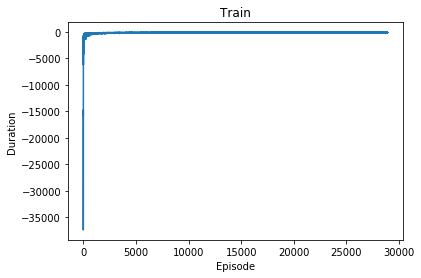

In [267]:
NUM_EPISODES = 100000

OPTIMIZE_MODEL_STEP = 5

TARGET_UPDATE=10000

STEPS_BEFORE_TRAIN = 50000

policy_net.train()
target_net.eval()
i = 0
test_rewards = []


for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    ep_rewards = []
    state = env.reset()
    for t in count():
        action = select_action(state)
        new_state, reward, done, info = env.step(action.item())
        ep_rewards.append(reward)
        reward = reward + 300 * (0.99 * abs(new_state[1]) - abs(state[1]))
        reward = torch.tensor([reward], device=device)
        
        
        if not done:
            memory.push(state, action, (new_state), reward)
            state = new_state
        else:
            next_state = env.reset()
            memory.push(state, action, (new_state), reward)
            
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            if (not i):
                print("start train")
                i = 1
            optimize_model()
        
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            print(steps_done)
            target_net.load_state_dict(policy_net.state_dict())
        

        if done:
            train_rewards.append(np.sum(ep_rewards))

            print("episode:", e, "  score:", train_rewards[-1], "  mean:",np.mean(train_rewards[-100:]))
            plot_rewards()
            break 



In [268]:
print("episode:", e, "  score:", train_rewards[-1], "  mean:",np.mean(train_rewards[-100:]))

episode: 28914   score: -157.0   mean: -141.28


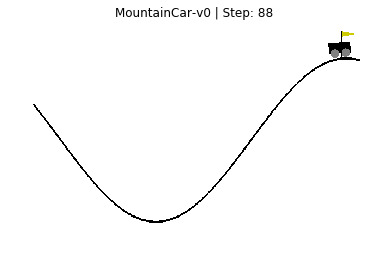

Total game reward : -90.0


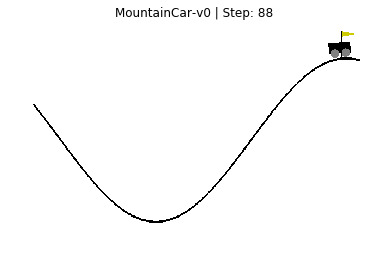

In [272]:
TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def select_action(state,eps_threshold):
    sample = random.random()
    state_batch =  torch.tensor(state).to(device).float()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_batch).max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

policy_net.eval()

state = env.reset()
total_reward = 0

for i in count():
    action = select_action(state, TEST_EPS)
    next_t, reward, done, _ = env.step(action.item())
    total_reward += reward
    if not done:
        state = next_t
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))

In [270]:
def save_model():
    print("Model Save...")
    torch.save(policy_net.state_dict(), 'policy.pth')
    torch.save(target_net.state_dict(), 'target.pth')

In [271]:
save_model()

Model Save...
